In [1]:
# import libraries
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
image_list = glob.glob('camera_cal/*.jpg')

def DisplayImage(image_list):
    fig,axs = plt.subplots(int(len(image_list)/4), 4, figsize=(20, 15))
    for ax, image in zip(axs.flat, image_list):
        image = plt.imread(image)
        ax.imshow(image)
    plt.show()


def plotImages(images, imageCaps, colormap = 'rgb'):
    f, axes= plt.subplots(1,len(imageCaps),figsize=(15,15))    
    for index, image in enumerate(images):
        axes[index].set_title(imageCaps[index], fontsize=10)
        if (colormap == 'gray'):
            axes[index].imshow(images[index], cmap='gray') 
        else:
            axes[index].imshow(images[index]) 
    
#DisplayImage(image_list)

In [3]:
#creating arrays
objpoints = []
imgpoints = []
outimages = []
originalImages = []

objp = np.zeros((6*9,3), np.float32) 
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x and y cordinates.

for image_path in image_list:
    image = plt.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

        ImgWithPoints = cv2.drawChessboardCorners(image.copy(), (9,6), corners, ret)
        outimages.append(ImgWithPoints)
        originalImages.append(image)

#plotting one sample image
#plotImages([originalImages[16],outimages[16]],['Original Image', 'Image with Chessboard Corners'])

print('Image with corner found: {}'.format(len(outimages)))

Image with corner found: 17


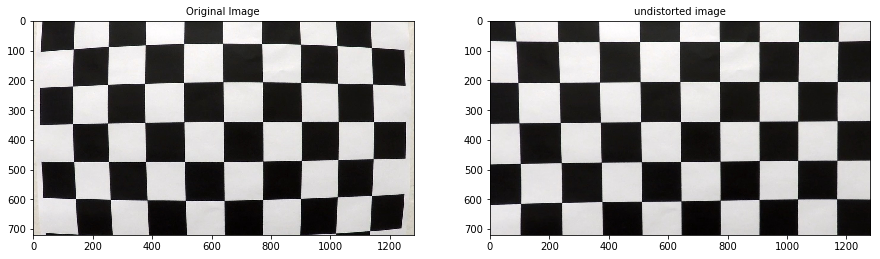

In [22]:
# camera caliberation

image = plt.imread(image_list[8])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (image.shape[1], image.shape[0]), None, None)


def getUndistImage(image):
    return cv2.undistort(image, mtx, dist, None, mtx)

plotImages([image,getUndistImage(image)],['Original Image', 'undistorted image'])

In [5]:
import pickle
pickle.dump( { 'mtx': mtx, 'dist': dist }, open('./pickled_data/camera_calibration.p', 'wb'))

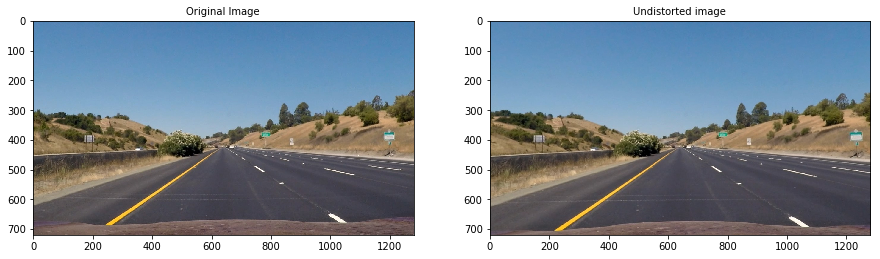

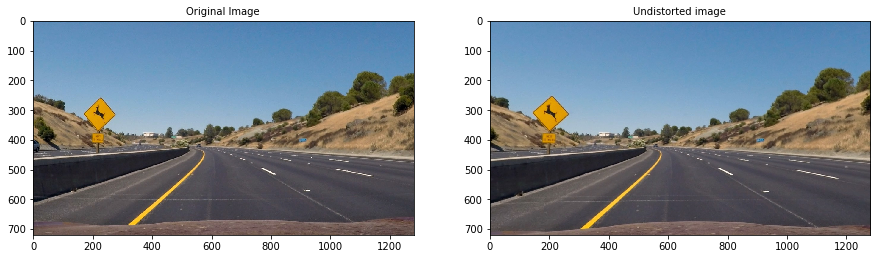

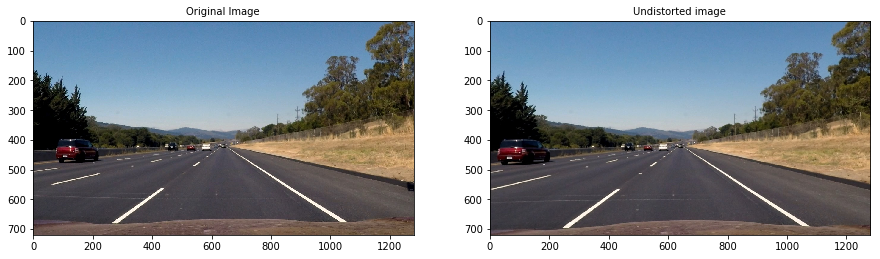

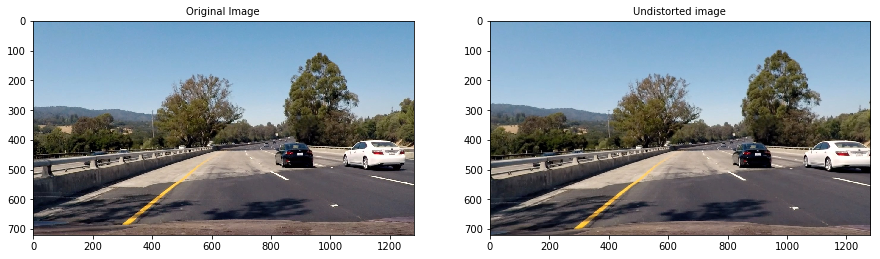

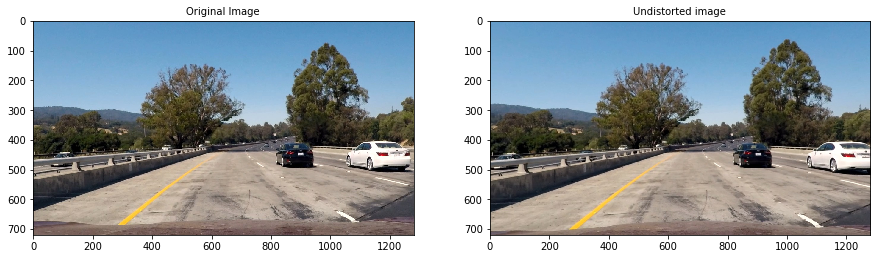

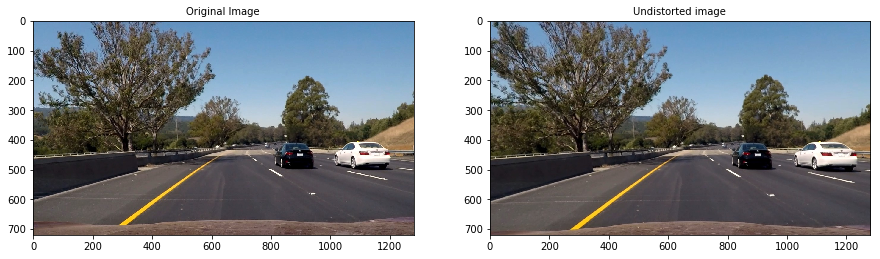

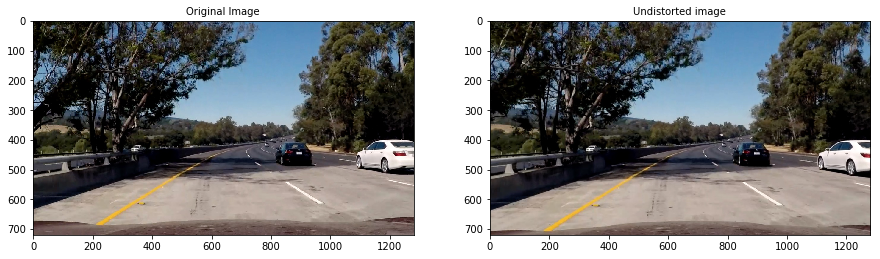

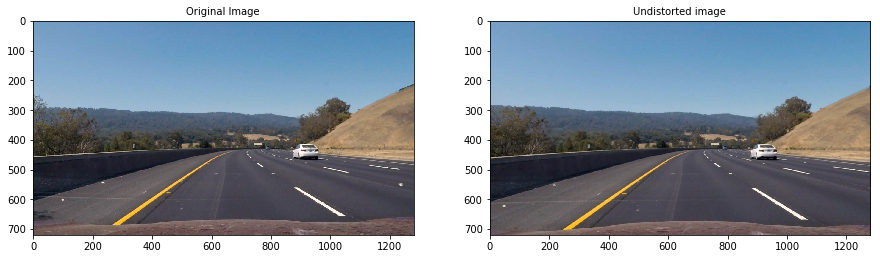

In [23]:
# getting undistorted images of test images
test_images = glob.glob('test_images/*.jpg')

for image in test_images:
    image = plt.imread(image)
    plotImages([image,getUndistImage(image)],['Original Image', 'Undistorted image'])

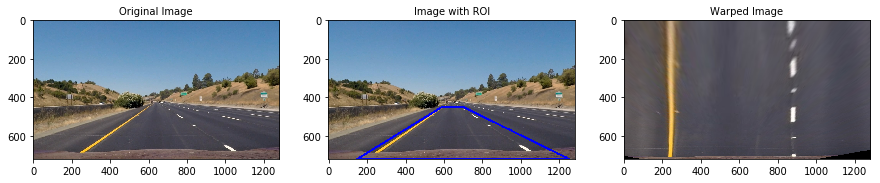

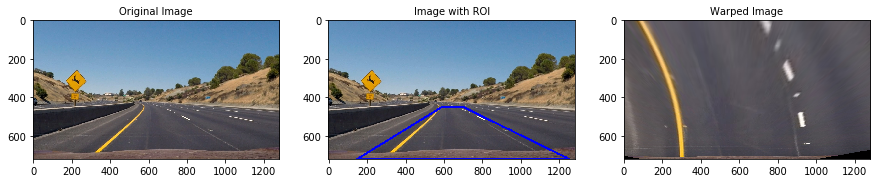

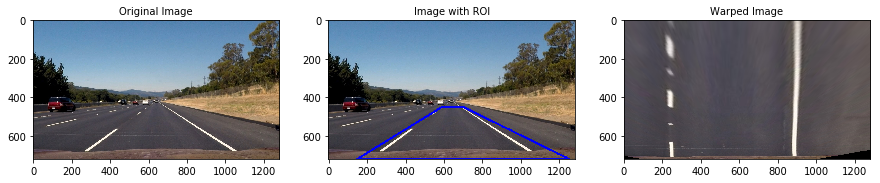

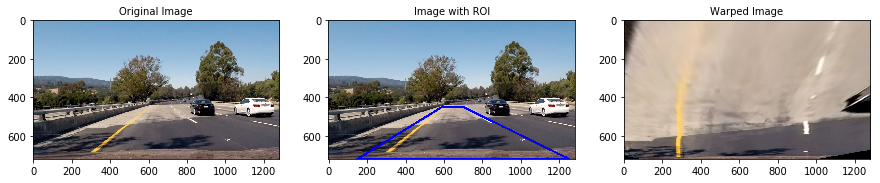

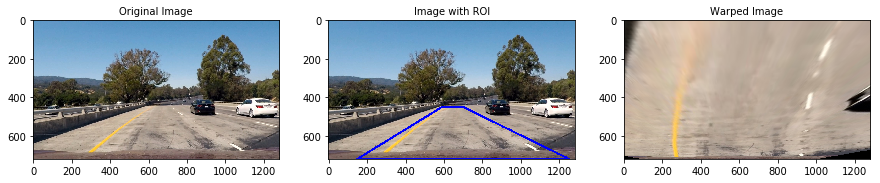

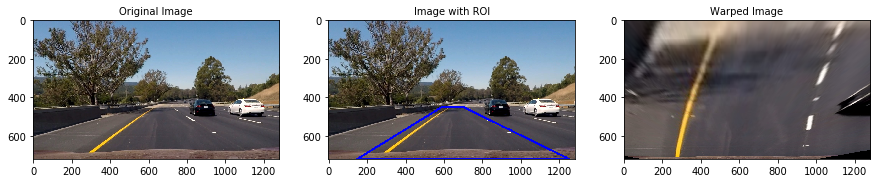

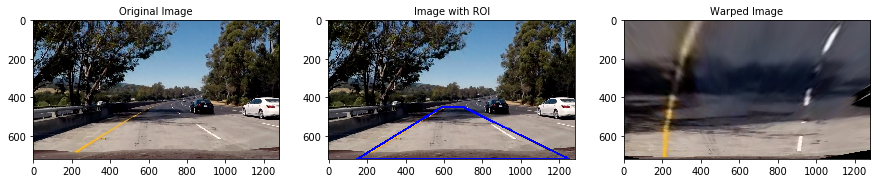

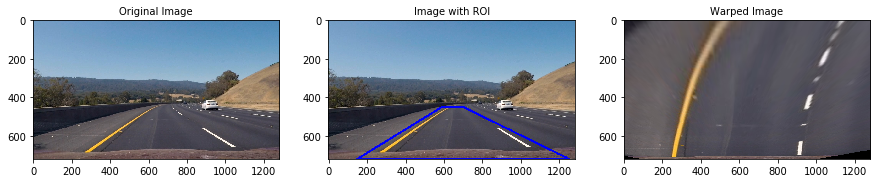

In [25]:
# defining Region Of Interest (ROI)

def drawROI(image, vertices):
    return cv2.polylines(image,vertices,True,(0,0,255),10)

def WarpPerspective(image):
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return Minv, cv2.warpPerspective(image, M, (image.shape[1],image.shape[0]), flags=cv2.INTER_LINEAR)
    

src=np.float32([[150,720], [590,450], [700,450], [1250,720]])
dst= np.float32([[200 ,720], [200  ,0], [980 ,0], [980 ,720]])

vertices = np.array([src], dtype=np.int32)


for image in test_images:
    image = plt.imread(image)
    roi_image = drawROI(image.copy(), vertices)
    M, warped_image = WarpPerspective(image.copy())
    plotImages([image , roi_image, warped_image],['Original Image', 'Image with ROI', 'Warped Image'])
        

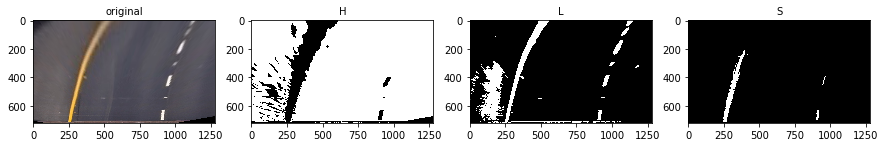

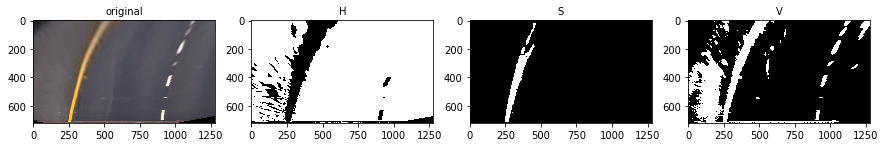

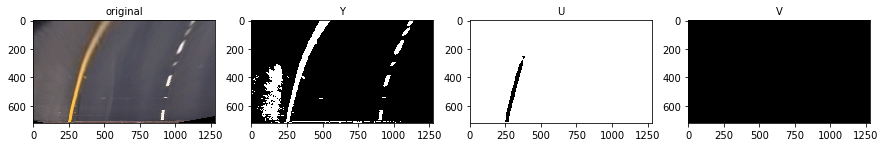

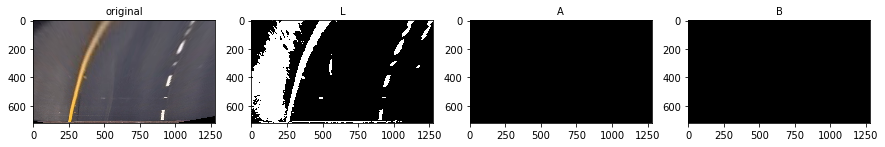

In [24]:
def extractChannels(image, threshold, colorspace, channel = 4) :    
    colorspace = 'cv2.COLOR_RGB2' + colorspace
    binary_output = [[],[],[]]
    if (channel == 4):
        for i in range(image.ndim):
            single_channel = cv2.cvtColor(image, eval(colorspace))[:,:,i]
            binary = np.zeros_like(single_channel)
            binary[(single_channel >= threshold[0]) & (single_channel <= threshold[1])] = 1
            binary_output[i] = binary
        return binary_output
    else:
        single_channel = cv2.cvtColor(image, eval(colorspace))[:,:,channel]
        binary = np.zeros_like(single_channel)
        binary[(single_channel >= threshold[0]) & (single_channel <= threshold[1])] = 1
        return binary

threshold= [100,255]   
colorspaces = ['HLS', 'HSV' , 'YUV' , 'LAB' ]

#test_image = plt.imread(test_images[0])
#warped_image = WarpPerspective(test_image.copy())

for space in colorspaces:
    test = extractChannels(warped_image, threshold, space )
    plotImages([warped_image ,test[0],test[1],test[2]],['original', space[0], space[1], space[2]], 'gray' )


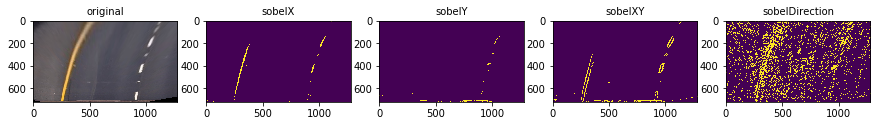

In [9]:
def ApplySobel(warpedimage, threshold, Type, kernelSize=3):    
    
    gray = cv2.cvtColor(warpedimage, cv2.COLOR_RGB2GRAY)
    
    sobelx_bin = cv2.Sobel(gray,cv2.CV_64F, 1, 0, ksize=kernelSize)
    sobely_bin = cv2.Sobel(gray,cv2.CV_64F, 0, 1, ksize=kernelSize)
    
    binary = sobelx_bin
    
    if (Type == 'sobelX'):
        binary = sobelx_bin
    elif (Type == 'sobelY'):
        binary = sobely_bin
    elif (Type == 'sobelXY'):
        binary = np.sqrt(sobelx_bin**2 + sobely_bin**2)
    elif (Type == 'sobelDirection'):
        binary = np.arctan2(np.absolute(sobely_bin),np.absolute(sobelx_bin))    

    binary_normalized = np.uint8((binary* 255)/np.max(binary)) # Creating a normalized sobel image
    binary_output = np.zeros_like(binary_normalized)
    binary_output[(binary_normalized > threshold[0]) & (binary_normalized < threshold[1])]=1
    return binary_output

threshold=[20,100]


imgX = ApplySobel(warped_image, threshold, 'sobelX', kernelSize=3)
imgY = ApplySobel(warped_image, threshold, 'sobelY', kernelSize=3)
imgXY = ApplySobel(warped_image, threshold, 'sobelXY', kernelSize=3)
imgDirection = ApplySobel(warped_image, threshold, 'sobelDirection', kernelSize=3)

plotImages([warped_image ,imgX ,imgY,imgXY,imgDirection],['original', 'sobelX', 'sobelY', 'sobelXY','sobelDirection'])

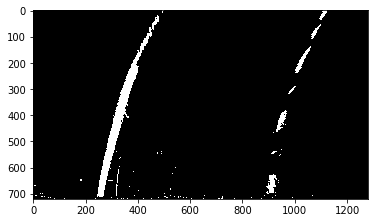

In [26]:
def advancedSobel(warped_image, color_threshold, sobel_threshold):
    
    s_channel = extractChannels(warped_image, color_threshold, 'HLS',2)
    l_channel = extractChannels(warped_image, color_threshold,'HLS',1)
    y_channel= extractChannels(warped_image, color_threshold,'YUV',0)
    
    sobelx = ApplySobel(warped_image, sobel_threshold, 'sobelX')
    sobeldir= ApplySobel(warped_image, [0.7,25], 'sobelDirection')
    #sobelxy=Sobel(warpedImage, sobel_threshold, 'xy')
    combined_binary = np.zeros_like(s_channel)
    combined_binary[(((s_channel == 1) & (l_channel==1)) & (y_channel==1)) | (sobelx == 1)  ] = 1
    return combined_binary

combinedImage = advancedSobel(warped_image,[100,255],[10,150])
plt.imshow(combinedImage,cmap='gray')

In [11]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low), (win_xleft_high,win_y_high),(0,255,0), 2)
        
        #cv2.rectangle(out_img,(win_xright_low,win_y_low), (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty

In [12]:
def fit_polynomial(binary_warped,warped_image,leftx, lefty, rightx, righty):
    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )    
    
    ##Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    '''
    #visualization
    binary_ini = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(binary_ini)
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    cv2.polylines(window_img, np.int32([pts_left]), isClosed=False, color=(0,255,0) , thickness=10)
    cv2.polylines(window_img, np.int32([pts_right]), isClosed=False, color=(0,255,0), thickness=10)
    binary_out = cv2.addWeighted(warped_image, 0.7, window_img, 1, 0)
    plt.imshow(binary_out)
    '''
    
    return left_fit, right_fit, left_fitx, right_fitx, ploty

In [13]:
def FindRadius(binary_warped,left_fit,right_fit):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty +left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature    
    y_eval=np.max(ploty)
    
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
      
    # Now our radius of curvature is in meters
    #print(left_curverad, 'm', right_curverad, 'm')
    return left_curverad, right_curverad

In [14]:
def search_around_poly(binary_warped, warped_image):     
    
    leftx, lefty, rightx, righty = find_lane_pixels(binary_warped)
    
    left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(binary_warped, warped_image, leftx, lefty, rightx, righty)
    
    left_curverad, right_curverad = FindRadius(binary_warped, left_fit, right_fit)
    
    
    print('left_curverad',left_curverad,'right_curverad', right_curverad)
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    binary_out = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(binary_out)
    

    #filling road surface
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    cv2.fillPoly(window_img, np.int_([pts]), (0,255, 0))    
    cv2.polylines(window_img, np.int32([pts_left]), isClosed=False, color=(255,255,0), thickness=15)
    cv2.polylines(window_img, np.int32([pts_right]), isClosed=False, color=(255,255,0), thickness=15)
    
    return window_img, left_curverad, right_curverad

left_curverad 405.010535298 right_curverad 291.275576307


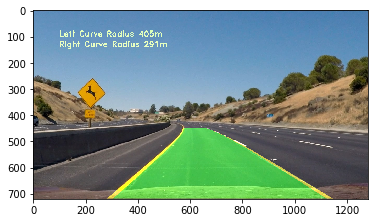

In [20]:

def pipeline(test_image):
    undist_image = getUndistImage(test_image.copy())
    Minv, warped_image = WarpPerspective(undist_image)
    binary_warped = advancedSobel(warped_image,color_threshold= [100,255],sobel_threshold=[10,150])

    h,w= binary_warped.shape
    
    result_img, left_curverad, right_curverad = search_around_poly(binary_warped, warped_image)
    #result_img = search_around_poly(binary_warped)
 
    result_img_inv = cv2.warpPerspective(result_img, Minv, (w, h)) 
    
    cv2.putText(result_img_inv,"Left Curve Radius " + str(int(left_curverad))+ "m", (100,100), 2, 1, (255,255,0),2)
    cv2.putText(result_img_inv,"Right Curve Radius " + str(int(right_curverad))+ "m", (100,140), 2, 1, (255,255,0),2)
    
    # Combine the result with the original image
    result_out_img = cv2.addWeighted(test_image, 1, result_img_inv, 0.5, 0)
    
    #plt.imshow(warped_image)
    return result_out_img



test_image = plt.imread(test_images[1])
result = pipeline(test_image)
plt.imshow(result)

In [21]:
#video processing

import moviepy
from moviepy.editor import VideoFileClip
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')
processed_video = video_input1.fl_image(pipeline)
%time processed_video.write_videofile(video_output1, audio=False)


left_curverad 420.301337085 right_curverad 594.27192973
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

left_curverad 420.301337085 right_curverad 594.27192973


  0%|          | 2/1261 [00:00<04:21,  4.82it/s]

left_curverad 404.288910256 right_curverad 582.662438484
left_curverad 404.883755705 right_curverad 695.629841296


  0%|          | 4/1261 [00:00<04:14,  4.94it/s]

left_curverad 410.07901533 right_curverad 610.057921523
left_curverad 419.177517557 right_curverad 548.309692352


  0%|          | 6/1261 [00:01<04:09,  5.04it/s]

left_curverad 421.921870955 right_curverad 464.750022079
left_curverad 444.127636184 right_curverad 463.273754247


  1%|          | 8/1261 [00:01<04:06,  5.08it/s]

left_curverad 453.460113584 right_curverad 390.515533045
left_curverad 499.674140921 right_curverad 419.071586548


  1%|          | 10/1261 [00:01<04:03,  5.14it/s]

left_curverad 507.504837328 right_curverad 496.853406956
left_curverad 491.26596834 right_curverad 592.783395297


  1%|          | 12/1261 [00:02<04:04,  5.11it/s]

left_curverad 542.964204625 right_curverad 634.626991331
left_curverad 564.160926039 right_curverad 640.025531879


  1%|          | 14/1261 [00:02<04:03,  5.11it/s]

left_curverad 545.55130094 right_curverad 645.437873531
left_curverad 505.342200456 right_curverad 712.117289549


  1%|▏         | 16/1261 [00:03<04:05,  5.08it/s]

left_curverad 485.788159564 right_curverad 466.386464921
left_curverad 469.899775003 right_curverad 417.4502228


  1%|▏         | 18/1261 [00:03<04:05,  5.07it/s]

left_curverad 470.701389478 right_curverad 396.235437369
left_curverad 475.823618955 right_curverad 416.559580231


  2%|▏         | 20/1261 [00:03<04:02,  5.11it/s]

left_curverad 486.528641053 right_curverad 376.824899919
left_curverad 512.922606897 right_curverad 323.36927485


  2%|▏         | 22/1261 [00:04<04:02,  5.10it/s]

left_curverad 498.152639392 right_curverad 343.784163846
left_curverad 529.849492779 right_curverad 387.764809934


  2%|▏         | 24/1261 [00:04<04:01,  5.12it/s]

left_curverad 479.808283981 right_curverad 436.231440961
left_curverad 449.206462549 right_curverad 537.492260499


  2%|▏         | 26/1261 [00:05<04:00,  5.13it/s]

left_curverad 476.329670969 right_curverad 531.639171018
left_curverad 437.042004024 right_curverad 539.899996437


  2%|▏         | 28/1261 [00:05<04:03,  5.07it/s]

left_curverad 454.976907237 right_curverad 560.593261015
left_curverad 413.812072038 right_curverad 538.047707983


  2%|▏         | 30/1261 [00:05<04:03,  5.05it/s]

left_curverad 384.19292868 right_curverad 559.933832555
left_curverad 355.943588959 right_curverad 446.319451874


  3%|▎         | 32/1261 [00:06<04:02,  5.06it/s]

left_curverad 324.196897304 right_curverad 343.181803077
left_curverad 338.334589359 right_curverad 301.539861491


  3%|▎         | 34/1261 [00:06<04:01,  5.09it/s]

left_curverad 320.858117472 right_curverad 295.637966659
left_curverad 314.325469076 right_curverad 331.364207456


  3%|▎         | 36/1261 [00:07<04:00,  5.10it/s]

left_curverad 302.219685272 right_curverad 343.031393921
left_curverad 295.659349212 right_curverad 342.921002296


  3%|▎         | 38/1261 [00:07<03:59,  5.10it/s]

left_curverad 292.46420816 right_curverad 363.179322551
left_curverad 290.905199132 right_curverad 448.453108625


  3%|▎         | 40/1261 [00:07<03:58,  5.11it/s]

left_curverad 300.785722747 right_curverad 460.469768074
left_curverad 301.658050679 right_curverad 356.775659912


  3%|▎         | 42/1261 [00:08<03:59,  5.10it/s]

left_curverad 307.468909613 right_curverad 349.929750252


  3%|▎         | 43/1261 [00:08<05:35,  3.63it/s]

left_curverad 327.857609991 right_curverad 327.050895628


  3%|▎         | 44/1261 [00:08<05:36,  3.61it/s]

left_curverad 345.867798311 right_curverad 335.509678013


  4%|▎         | 45/1261 [00:09<05:37,  3.60it/s]

left_curverad 365.482857643 right_curverad 325.81190589


  4%|▎         | 46/1261 [00:09<05:41,  3.56it/s]

left_curverad 378.718767976 right_curverad 287.590206127


  4%|▎         | 47/1261 [00:09<05:31,  3.66it/s]

left_curverad 400.387336736 right_curverad 309.553953275


  4%|▍         | 48/1261 [00:10<05:32,  3.65it/s]

left_curverad 412.866422672 right_curverad 327.197466858


  4%|▍         | 49/1261 [00:10<05:32,  3.64it/s]

left_curverad 445.947994725 right_curverad 346.525649819


  4%|▍         | 50/1261 [00:10<05:24,  3.73it/s]

left_curverad 444.802779955 right_curverad 380.972431396


  4%|▍         | 51/1261 [00:10<05:31,  3.65it/s]

left_curverad 471.458797767 right_curverad 423.346241938


  4%|▍         | 52/1261 [00:11<05:24,  3.72it/s]

left_curverad 449.004769748 right_curverad 455.288326419


  4%|▍         | 53/1261 [00:11<05:38,  3.57it/s]

left_curverad 450.678673079 right_curverad 506.201991582


  4%|▍         | 54/1261 [00:11<05:31,  3.65it/s]

left_curverad 449.640341859 right_curverad 477.146914966


  4%|▍         | 55/1261 [00:11<05:34,  3.61it/s]

left_curverad 463.772566316 right_curverad 431.379146103


  4%|▍         | 56/1261 [00:12<05:27,  3.68it/s]

left_curverad 478.945575431 right_curverad 413.907608161


  5%|▍         | 57/1261 [00:12<05:34,  3.60it/s]

left_curverad 479.006974657 right_curverad 397.345653385


  5%|▍         | 58/1261 [00:12<05:27,  3.67it/s]

left_curverad 483.567413379 right_curverad 363.064448071


  5%|▍         | 59/1261 [00:13<05:37,  3.56it/s]

left_curverad 456.682382502 right_curverad 372.714049824


  5%|▍         | 60/1261 [00:13<05:32,  3.61it/s]

left_curverad 451.076950261 right_curverad 398.767489185


  5%|▍         | 61/1261 [00:13<05:39,  3.54it/s]

left_curverad 440.24499459 right_curverad 387.70135743


  5%|▍         | 62/1261 [00:13<05:30,  3.62it/s]

left_curverad 429.275994269 right_curverad 361.448435864


  5%|▍         | 63/1261 [00:14<05:39,  3.53it/s]

left_curverad 445.114128087 right_curverad 368.777422558


  5%|▌         | 64/1261 [00:14<05:32,  3.61it/s]

left_curverad 419.39575268 right_curverad 335.480100977


  5%|▌         | 65/1261 [00:14<05:36,  3.55it/s]

left_curverad 456.868210839 right_curverad 317.675398829


  5%|▌         | 66/1261 [00:15<05:28,  3.63it/s]

left_curverad 443.156080893 right_curverad 349.717023709


  5%|▌         | 67/1261 [00:15<05:36,  3.55it/s]

left_curverad 457.712851328 right_curverad 392.681020924


  5%|▌         | 68/1261 [00:15<05:38,  3.53it/s]

left_curverad 486.10778186 right_curverad 389.864609844


  5%|▌         | 69/1261 [00:15<05:35,  3.56it/s]

left_curverad 461.202411443 right_curverad 399.302745983


  6%|▌         | 70/1261 [00:16<05:43,  3.47it/s]

left_curverad 495.512811294 right_curverad 390.834699502


  6%|▌         | 71/1261 [00:16<05:29,  3.61it/s]

left_curverad 507.017408835 right_curverad 299.626504609


  6%|▌         | 72/1261 [00:16<05:31,  3.58it/s]

left_curverad 534.020877455 right_curverad 330.771271923


  6%|▌         | 73/1261 [00:17<05:41,  3.47it/s]

left_curverad 531.166142684 right_curverad 345.993895941


  6%|▌         | 74/1261 [00:17<05:46,  3.43it/s]

left_curverad 548.416843346 right_curverad 382.793295513


  6%|▌         | 75/1261 [00:17<05:31,  3.58it/s]

left_curverad 588.280997099 right_curverad 407.466218112


  6%|▌         | 76/1261 [00:17<05:38,  3.50it/s]

left_curverad 573.47570388 right_curverad 443.377281166


  6%|▌         | 77/1261 [00:18<05:23,  3.66it/s]

left_curverad 637.711560273 right_curverad 464.323773952


  6%|▌         | 78/1261 [00:18<05:28,  3.60it/s]

left_curverad 667.479527677 right_curverad 463.10798229


  6%|▋         | 79/1261 [00:18<05:31,  3.56it/s]

left_curverad 664.83688447 right_curverad 461.854335175


  6%|▋         | 80/1261 [00:18<05:24,  3.64it/s]

left_curverad 620.388199369 right_curverad 468.845922986


  6%|▋         | 81/1261 [00:19<05:27,  3.61it/s]

left_curverad 596.667101737 right_curverad 397.790028772


  7%|▋         | 82/1261 [00:19<05:19,  3.69it/s]

left_curverad 564.389072972 right_curverad 389.875721754


  7%|▋         | 83/1261 [00:19<05:19,  3.69it/s]

left_curverad 550.834500805 right_curverad 351.394916575


  7%|▋         | 84/1261 [00:20<05:28,  3.59it/s]

left_curverad 562.802511928 right_curverad 382.226538402


  7%|▋         | 85/1261 [00:20<05:16,  3.71it/s]

left_curverad 523.127177317 right_curverad 395.10790136


  7%|▋         | 86/1261 [00:20<05:24,  3.62it/s]

left_curverad 510.715766502 right_curverad 430.572990143


  7%|▋         | 87/1261 [00:20<05:24,  3.62it/s]

left_curverad 461.538073168 right_curverad 486.670784627


  7%|▋         | 88/1261 [00:21<05:29,  3.56it/s]

left_curverad 426.888141794 right_curverad 459.603723937


  7%|▋         | 89/1261 [00:21<05:17,  3.69it/s]

left_curverad 403.882661505 right_curverad 514.97298497


  7%|▋         | 90/1261 [00:21<05:34,  3.50it/s]

left_curverad 370.297687943 right_curverad 398.19932917


  7%|▋         | 91/1261 [00:22<05:21,  3.63it/s]

left_curverad 380.728411652 right_curverad 388.633591624


  7%|▋         | 92/1261 [00:22<05:35,  3.49it/s]

left_curverad 386.337113239 right_curverad 369.487117741


  7%|▋         | 93/1261 [00:22<05:22,  3.62it/s]

left_curverad 367.75906932 right_curverad 369.900970346


  7%|▋         | 94/1261 [00:22<05:29,  3.54it/s]

left_curverad 363.765986722 right_curverad 382.077620295


  8%|▊         | 95/1261 [00:23<05:31,  3.52it/s]

left_curverad 379.894682303 right_curverad 380.402271287


  8%|▊         | 96/1261 [00:23<05:22,  3.61it/s]

left_curverad 392.791517699 right_curverad 329.433517278


  8%|▊         | 97/1261 [00:23<05:20,  3.63it/s]

left_curverad 384.525537037 right_curverad 372.228286921


  8%|▊         | 98/1261 [00:23<05:23,  3.60it/s]

left_curverad 395.331869985 right_curverad 415.631103675


  8%|▊         | 99/1261 [00:24<05:25,  3.57it/s]

left_curverad 385.943465792 right_curverad 363.76534449


  8%|▊         | 100/1261 [00:24<05:19,  3.64it/s]

left_curverad 392.628617518 right_curverad 416.803648231


  8%|▊         | 101/1261 [00:24<05:19,  3.63it/s]

left_curverad 373.874434961 right_curverad 415.075668277


  8%|▊         | 102/1261 [00:25<05:31,  3.49it/s]

left_curverad 363.350889346 right_curverad 440.0063852


  8%|▊         | 103/1261 [00:25<05:18,  3.64it/s]

left_curverad 365.726918375 right_curverad 449.544301388


  8%|▊         | 104/1261 [00:25<05:26,  3.54it/s]

left_curverad 359.639780605 right_curverad 354.968583478


  8%|▊         | 105/1261 [00:26<05:57,  3.23it/s]

left_curverad 384.443192448 right_curverad 431.594723805


  8%|▊         | 106/1261 [00:26<05:41,  3.38it/s]

left_curverad 393.721902453 right_curverad 383.227257673


  8%|▊         | 107/1261 [00:26<05:39,  3.40it/s]

left_curverad 402.295155213 right_curverad 381.499824667


  9%|▊         | 108/1261 [00:26<05:27,  3.52it/s]

left_curverad 373.074139265 right_curverad 317.072165617


  9%|▊         | 109/1261 [00:27<05:28,  3.50it/s]

left_curverad 369.997215309 right_curverad 302.501638593


  9%|▊         | 110/1261 [00:27<05:17,  3.63it/s]

left_curverad 364.818436851 right_curverad 326.392562963


  9%|▉         | 111/1261 [00:27<05:22,  3.57it/s]

left_curverad 359.734741735 right_curverad 360.326876641


  9%|▉         | 112/1261 [00:27<05:12,  3.68it/s]

left_curverad 379.819286998 right_curverad 394.518437509


  9%|▉         | 113/1261 [00:28<05:18,  3.60it/s]

left_curverad 358.953570201 right_curverad 383.701357761


  9%|▉         | 114/1261 [00:28<05:12,  3.67it/s]

left_curverad 355.126231424 right_curverad 388.002431804


  9%|▉         | 115/1261 [00:28<05:17,  3.61it/s]

left_curverad 337.46525488 right_curverad 413.734044492


  9%|▉         | 116/1261 [00:29<05:10,  3.69it/s]

left_curverad 332.954967045 right_curverad 361.868467072


  9%|▉         | 117/1261 [00:29<05:17,  3.61it/s]

left_curverad 336.554541678 right_curverad 368.091393622


  9%|▉         | 118/1261 [00:29<05:10,  3.68it/s]

left_curverad 338.925072517 right_curverad 313.142363729


  9%|▉         | 119/1261 [00:29<05:15,  3.62it/s]

left_curverad 340.262091599 right_curverad 310.315548092


 10%|▉         | 120/1261 [00:30<05:12,  3.65it/s]

left_curverad 323.647837278 right_curverad 321.072907225


 10%|▉         | 121/1261 [00:30<05:16,  3.61it/s]

left_curverad 336.703139482 right_curverad 300.142599466


 10%|▉         | 122/1261 [00:30<05:24,  3.51it/s]

left_curverad 337.85872281 right_curverad 296.307184741


 10%|▉         | 123/1261 [00:30<05:10,  3.66it/s]

left_curverad 333.240957313 right_curverad 306.818397732


 10%|▉         | 124/1261 [00:31<05:19,  3.56it/s]

left_curverad 346.313293145 right_curverad 309.13509406


 10%|▉         | 125/1261 [00:31<05:06,  3.71it/s]

left_curverad 345.869657024 right_curverad 330.434428509


 10%|▉         | 126/1261 [00:31<05:16,  3.59it/s]

left_curverad 377.666724781 right_curverad 413.400411022


 10%|█         | 127/1261 [00:32<05:05,  3.71it/s]

left_curverad 371.566913507 right_curverad 398.461269195


 10%|█         | 128/1261 [00:32<05:17,  3.57it/s]

left_curverad 384.64214865 right_curverad 413.184359709


 10%|█         | 129/1261 [00:32<05:06,  3.70it/s]

left_curverad 366.863790629 right_curverad 334.732751994


 10%|█         | 130/1261 [00:32<05:14,  3.60it/s]

left_curverad 383.982053118 right_curverad 362.396765433


 10%|█         | 131/1261 [00:33<05:04,  3.72it/s]

left_curverad 387.195383157 right_curverad 360.6880448


 10%|█         | 132/1261 [00:33<05:16,  3.56it/s]

left_curverad 377.631314925 right_curverad 354.689451365


 11%|█         | 133/1261 [00:33<05:06,  3.68it/s]

left_curverad 389.287822117 right_curverad 361.356269272


 11%|█         | 134/1261 [00:34<05:13,  3.60it/s]

left_curverad 401.362049104 right_curverad 319.007793031


 11%|█         | 135/1261 [00:34<05:15,  3.57it/s]

left_curverad 412.882597416 right_curverad 331.618050664


 11%|█         | 136/1261 [00:34<05:08,  3.65it/s]

left_curverad 431.682142409 right_curverad 347.022918533


 11%|█         | 137/1261 [00:34<05:07,  3.66it/s]

left_curverad 451.899196702 right_curverad 406.293247002


 11%|█         | 138/1261 [00:35<05:11,  3.60it/s]

left_curverad 491.542468905 right_curverad 426.817931654


 11%|█         | 139/1261 [00:35<05:01,  3.72it/s]

left_curverad 498.580419032 right_curverad 534.084189601


 11%|█         | 140/1261 [00:35<05:13,  3.58it/s]

left_curverad 532.866838385 right_curverad 595.432449644


 11%|█         | 141/1261 [00:35<05:01,  3.71it/s]

left_curverad 525.942215005 right_curverad 593.860228788


 11%|█▏        | 142/1261 [00:36<05:14,  3.55it/s]

left_curverad 522.957116996 right_curverad 551.213985991


 11%|█▏        | 143/1261 [00:36<05:02,  3.70it/s]

left_curverad 494.255906615 right_curverad 419.825526875


 11%|█▏        | 144/1261 [00:36<05:09,  3.61it/s]

left_curverad 487.865821557 right_curverad 405.476248164


 11%|█▏        | 145/1261 [00:37<05:13,  3.55it/s]

left_curverad 479.494188539 right_curverad 400.935386977


 12%|█▏        | 146/1261 [00:37<05:21,  3.47it/s]

left_curverad 458.717274763 right_curverad 404.074419307


 12%|█▏        | 147/1261 [00:37<06:17,  2.95it/s]

left_curverad 468.982875572 right_curverad 370.509905851


 12%|█▏        | 148/1261 [00:38<05:54,  3.14it/s]

left_curverad 408.687214608 right_curverad 403.878133946


 12%|█▏        | 149/1261 [00:38<05:46,  3.21it/s]

left_curverad 412.217529556 right_curverad 471.931555462


 12%|█▏        | 150/1261 [00:38<05:33,  3.34it/s]

left_curverad 433.584264785 right_curverad 482.403884041


 12%|█▏        | 151/1261 [00:38<05:27,  3.38it/s]

left_curverad 435.414307787 right_curverad 435.222541046


 12%|█▏        | 152/1261 [00:39<05:18,  3.49it/s]

left_curverad 447.745209528 right_curverad 528.287229133


 12%|█▏        | 153/1261 [00:39<05:18,  3.48it/s]

left_curverad 419.523085161 right_curverad 404.467735432


 12%|█▏        | 154/1261 [00:39<05:08,  3.58it/s]

left_curverad 449.785974772 right_curverad 468.231551838


 12%|█▏        | 155/1261 [00:40<05:06,  3.61it/s]

left_curverad 457.411694104 right_curverad 463.513874139


 12%|█▏        | 156/1261 [00:40<05:12,  3.54it/s]

left_curverad 453.391790218 right_curverad 397.536585613


 12%|█▏        | 157/1261 [00:40<04:59,  3.69it/s]

left_curverad 444.745978592 right_curverad 393.881485953


 13%|█▎        | 158/1261 [00:40<05:07,  3.59it/s]

left_curverad 410.834471591 right_curverad 396.254511182


 13%|█▎        | 159/1261 [00:41<04:56,  3.71it/s]

left_curverad 422.301012087 right_curverad 337.74122172


 13%|█▎        | 160/1261 [00:41<05:04,  3.62it/s]

left_curverad 400.134866301 right_curverad 307.343777801


 13%|█▎        | 161/1261 [00:41<05:07,  3.58it/s]

left_curverad 419.781355836 right_curverad 355.581513874


 13%|█▎        | 162/1261 [00:41<05:00,  3.65it/s]

left_curverad 420.956066131 right_curverad 367.562264586


 13%|█▎        | 163/1261 [00:42<05:07,  3.57it/s]

left_curverad 440.695894137 right_curverad 396.587783572


 13%|█▎        | 164/1261 [00:42<05:10,  3.54it/s]

left_curverad 413.163652506 right_curverad 417.503026191


 13%|█▎        | 165/1261 [00:42<05:06,  3.58it/s]

left_curverad 388.413331871 right_curverad 266.128803594


 13%|█▎        | 166/1261 [00:43<05:11,  3.52it/s]

left_curverad 391.637042938 right_curverad 293.298378617


 13%|█▎        | 167/1261 [00:43<04:59,  3.66it/s]

left_curverad 354.501279782 right_curverad 276.09599427


 13%|█▎        | 168/1261 [00:43<05:07,  3.55it/s]

left_curverad 393.888461333 right_curverad 283.466274069


 13%|█▎        | 169/1261 [00:43<04:55,  3.70it/s]

left_curverad 404.040904653 right_curverad 289.141463593


 13%|█▎        | 170/1261 [00:44<05:04,  3.58it/s]

left_curverad 428.840743896 right_curverad 280.344919083


 14%|█▎        | 171/1261 [00:44<04:54,  3.71it/s]

left_curverad 431.671623187 right_curverad 239.082059715


 14%|█▎        | 172/1261 [00:44<04:59,  3.63it/s]

left_curverad 414.862943223 right_curverad 246.756286225


 14%|█▎        | 173/1261 [00:45<05:02,  3.60it/s]

left_curverad 391.756566709 right_curverad 242.126811138


 14%|█▍        | 174/1261 [00:45<04:56,  3.67it/s]

left_curverad 352.069882244 right_curverad 259.301461514


 14%|█▍        | 175/1261 [00:45<05:02,  3.59it/s]

left_curverad 340.009285492 right_curverad 258.505045195


 14%|█▍        | 176/1261 [00:45<04:56,  3.67it/s]

left_curverad 329.359335796 right_curverad 239.967660613


 14%|█▍        | 177/1261 [00:46<05:01,  3.59it/s]

left_curverad 362.012334856 right_curverad 296.231246601


 14%|█▍        | 178/1261 [00:46<04:56,  3.65it/s]

left_curverad 358.565020058 right_curverad 278.092122192


 14%|█▍        | 179/1261 [00:46<04:58,  3.62it/s]

left_curverad 353.519353219 right_curverad 261.943396555


 14%|█▍        | 180/1261 [00:46<05:07,  3.52it/s]

left_curverad 360.15431438 right_curverad 280.249151323


 14%|█▍        | 181/1261 [00:47<04:56,  3.64it/s]

left_curverad 327.309627639 right_curverad 261.250073927


 14%|█▍        | 182/1261 [00:47<05:03,  3.56it/s]

left_curverad 334.370778265 right_curverad 272.108947585


 15%|█▍        | 183/1261 [00:47<04:52,  3.69it/s]

left_curverad 312.425411609 right_curverad 286.528720839


 15%|█▍        | 184/1261 [00:48<04:58,  3.60it/s]

left_curverad 294.409086016 right_curverad 250.696350667


 15%|█▍        | 185/1261 [00:48<04:58,  3.61it/s]

left_curverad 280.338070872 right_curverad 256.645141536


 15%|█▍        | 186/1261 [00:48<04:58,  3.60it/s]

left_curverad 250.005874875 right_curverad 228.704314317


 15%|█▍        | 187/1261 [00:48<04:59,  3.59it/s]

left_curverad 252.659003865 right_curverad 226.589612987


 15%|█▍        | 188/1261 [00:49<05:04,  3.52it/s]

left_curverad 248.091349058 right_curverad 233.582593051


 15%|█▍        | 189/1261 [00:49<04:52,  3.66it/s]

left_curverad 255.291533808 right_curverad 251.304083545


 15%|█▌        | 190/1261 [00:49<04:58,  3.59it/s]

left_curverad 256.669571467 right_curverad 267.020406772


 15%|█▌        | 191/1261 [00:50<05:01,  3.55it/s]

left_curverad 253.627518461 right_curverad 305.206459155


 15%|█▌        | 192/1261 [00:50<04:56,  3.60it/s]

left_curverad 266.961461377 right_curverad 325.436215848


 15%|█▌        | 193/1261 [00:50<05:02,  3.53it/s]

left_curverad 262.417089125 right_curverad 293.841349209


 15%|█▌        | 194/1261 [00:50<05:04,  3.50it/s]

left_curverad 273.763858565 right_curverad 284.601505312


 15%|█▌        | 195/1261 [00:51<05:04,  3.51it/s]

left_curverad 278.602604841 right_curverad 259.107795373


 16%|█▌        | 196/1261 [00:51<04:56,  3.59it/s]

left_curverad 340.014201884 right_curverad 268.142465942


 16%|█▌        | 197/1261 [00:51<04:59,  3.55it/s]

left_curverad 400.150988634 right_curverad 316.785071052


 16%|█▌        | 198/1261 [00:52<05:05,  3.48it/s]

left_curverad 447.157355735 right_curverad 338.560685947


 16%|█▌        | 199/1261 [00:52<04:53,  3.62it/s]

left_curverad 510.233819562 right_curverad 355.162319771


 16%|█▌        | 200/1261 [00:52<05:03,  3.50it/s]

left_curverad 505.033237947 right_curverad 399.253761006


 16%|█▌        | 201/1261 [00:52<04:51,  3.64it/s]

left_curverad 528.407759826 right_curverad 483.759140857


 16%|█▌        | 202/1261 [00:53<04:56,  3.57it/s]

left_curverad 468.333865295 right_curverad 472.382058162


 16%|█▌        | 203/1261 [00:53<04:56,  3.57it/s]

left_curverad 434.488868717 right_curverad 506.461422203


 16%|█▌        | 204/1261 [00:53<04:46,  3.68it/s]

left_curverad 429.717992863 right_curverad 497.310050796


 16%|█▋        | 205/1261 [00:53<04:53,  3.60it/s]

left_curverad 397.140809582 right_curverad 378.098045359


 16%|█▋        | 206/1261 [00:54<04:47,  3.67it/s]

left_curverad 381.069738483 right_curverad 356.352676271


 16%|█▋        | 207/1261 [00:54<04:52,  3.61it/s]

left_curverad 340.322308828 right_curverad 370.90380843


 16%|█▋        | 208/1261 [00:54<04:45,  3.69it/s]

left_curverad 321.277749714 right_curverad 305.661992503


 17%|█▋        | 209/1261 [00:55<04:52,  3.59it/s]

left_curverad 337.064141134 right_curverad 301.427749462


 17%|█▋        | 210/1261 [00:55<04:50,  3.62it/s]

left_curverad 348.2015061 right_curverad 350.768587628


 17%|█▋        | 211/1261 [00:55<04:55,  3.56it/s]

left_curverad 377.711298754 right_curverad 399.933229576


 17%|█▋        | 212/1261 [00:55<04:48,  3.64it/s]

left_curverad 369.178751147 right_curverad 443.333329537


 17%|█▋        | 213/1261 [00:56<04:52,  3.59it/s]

left_curverad 374.656581062 right_curverad 514.58549171


 17%|█▋        | 214/1261 [00:56<04:45,  3.67it/s]

left_curverad 367.049701655 right_curverad 580.157020921


 17%|█▋        | 215/1261 [00:56<04:47,  3.63it/s]

left_curverad 368.35971121 right_curverad 624.030572505


 17%|█▋        | 216/1261 [00:56<04:42,  3.70it/s]

left_curverad 386.239761634 right_curverad 544.62163168


 17%|█▋        | 217/1261 [00:57<04:48,  3.62it/s]

left_curverad 376.181773831 right_curverad 432.960815646


 17%|█▋        | 218/1261 [00:57<04:41,  3.70it/s]

left_curverad 400.725355154 right_curverad 412.273231225


 17%|█▋        | 219/1261 [00:57<04:46,  3.63it/s]

left_curverad 383.547803664 right_curverad 374.03076042


 17%|█▋        | 220/1261 [00:58<04:41,  3.69it/s]

left_curverad 415.008476801 right_curverad 357.625385486


 18%|█▊        | 221/1261 [00:58<04:45,  3.64it/s]

left_curverad 430.199760733 right_curverad 342.856275097


 18%|█▊        | 222/1261 [00:58<04:40,  3.70it/s]

left_curverad 438.527699151 right_curverad 380.005633188


 18%|█▊        | 223/1261 [00:58<04:48,  3.60it/s]

left_curverad 456.960092529 right_curverad 399.068045822


 18%|█▊        | 224/1261 [00:59<04:52,  3.54it/s]

left_curverad 429.164293159 right_curverad 389.658157797


 18%|█▊        | 225/1261 [00:59<04:55,  3.51it/s]

left_curverad 445.628351709 right_curverad 416.370167156


 18%|█▊        | 226/1261 [00:59<04:47,  3.60it/s]

left_curverad 420.912989457 right_curverad 428.97090176


 18%|█▊        | 227/1261 [00:59<04:44,  3.64it/s]

left_curverad 440.288517153 right_curverad 458.760085857


 18%|█▊        | 228/1261 [01:00<04:45,  3.62it/s]

left_curverad 458.294164416 right_curverad 380.279654274


 18%|█▊        | 229/1261 [01:00<04:47,  3.59it/s]

left_curverad 465.571658788 right_curverad 337.625519335


 18%|█▊        | 230/1261 [01:00<04:40,  3.68it/s]

left_curverad 502.076084937 right_curverad 343.796998468


 18%|█▊        | 231/1261 [01:01<04:44,  3.61it/s]

left_curverad 478.850384189 right_curverad 324.371607437


 18%|█▊        | 232/1261 [01:01<04:38,  3.70it/s]

left_curverad 498.471794347 right_curverad 304.052712188


 18%|█▊        | 233/1261 [01:01<04:44,  3.61it/s]

left_curverad 497.950773787 right_curverad 275.366533532


 19%|█▊        | 234/1261 [01:01<04:37,  3.70it/s]

left_curverad 491.818844286 right_curverad 298.147553761


 19%|█▊        | 235/1261 [01:02<04:38,  3.69it/s]

left_curverad 478.372449738 right_curverad 304.06829557


 19%|█▊        | 236/1261 [01:02<04:44,  3.60it/s]

left_curverad 430.836923508 right_curverad 306.589178643


 19%|█▉        | 237/1261 [01:02<04:36,  3.71it/s]

left_curverad 423.380928555 right_curverad 305.582515132


 19%|█▉        | 238/1261 [01:03<04:47,  3.56it/s]

left_curverad 401.542576647 right_curverad 277.411015769


 19%|█▉        | 239/1261 [01:03<04:38,  3.67it/s]

left_curverad 389.332906809 right_curverad 268.924448018


 19%|█▉        | 240/1261 [01:03<04:49,  3.53it/s]

left_curverad 387.628018136 right_curverad 283.362590501


 19%|█▉        | 241/1261 [01:03<04:39,  3.65it/s]

left_curverad 391.406034292 right_curverad 309.283418372


 19%|█▉        | 242/1261 [01:04<04:47,  3.55it/s]

left_curverad 412.886195069 right_curverad 307.276052502


 19%|█▉        | 243/1261 [01:04<04:35,  3.70it/s]

left_curverad 378.350174363 right_curverad 305.926805841


 19%|█▉        | 244/1261 [01:04<04:40,  3.63it/s]

left_curverad 389.928450338 right_curverad 307.420510416


 19%|█▉        | 245/1261 [01:04<04:40,  3.63it/s]

left_curverad 380.32827164 right_curverad 240.293202358


 20%|█▉        | 246/1261 [01:05<04:33,  3.71it/s]

left_curverad 371.051987628 right_curverad 262.336496349


 20%|█▉        | 247/1261 [01:05<04:41,  3.60it/s]

left_curverad 382.427334419 right_curverad 262.653338933


 20%|█▉        | 248/1261 [01:05<04:35,  3.67it/s]

left_curverad 356.253731178 right_curverad 226.194161465


 20%|█▉        | 249/1261 [01:06<04:44,  3.56it/s]

left_curverad 378.576901357 right_curverad 263.418566849


 20%|█▉        | 250/1261 [01:06<04:37,  3.64it/s]

left_curverad 372.800717142 right_curverad 260.104283985


 20%|█▉        | 251/1261 [01:06<04:40,  3.61it/s]

left_curverad 383.149514807 right_curverad 277.699950851


 20%|█▉        | 252/1261 [01:06<04:33,  3.69it/s]

left_curverad 397.281489241 right_curverad 297.358375827


 20%|██        | 253/1261 [01:07<04:41,  3.58it/s]

left_curverad 404.704944261 right_curverad 328.792127074


 20%|██        | 254/1261 [01:07<04:50,  3.47it/s]

left_curverad 427.907315146 right_curverad 326.15162933


 20%|██        | 255/1261 [01:07<04:36,  3.64it/s]

left_curverad 405.914128128 right_curverad 323.756333116


 20%|██        | 256/1261 [01:07<04:36,  3.63it/s]

left_curverad 412.723720498 right_curverad 297.167430338


 20%|██        | 257/1261 [01:08<04:35,  3.65it/s]

left_curverad 409.232326746 right_curverad 255.00661996


 20%|██        | 258/1261 [01:08<04:41,  3.56it/s]

left_curverad 408.664840227 right_curverad 251.699002436


 21%|██        | 259/1261 [01:08<04:32,  3.67it/s]

left_curverad 414.780786387 right_curverad 263.688678872


 21%|██        | 260/1261 [01:09<04:40,  3.57it/s]

left_curverad 409.602716709 right_curverad 259.144117357


 21%|██        | 261/1261 [01:09<04:30,  3.69it/s]

left_curverad 447.516189797 right_curverad 373.955108553


 21%|██        | 262/1261 [01:09<04:40,  3.56it/s]

left_curverad 441.960017682 right_curverad 308.73115524


 21%|██        | 263/1261 [01:09<04:30,  3.69it/s]

left_curverad 438.113727398 right_curverad 344.942991402


 21%|██        | 264/1261 [01:10<04:35,  3.62it/s]

left_curverad 441.314013247 right_curverad 339.701572566


 21%|██        | 265/1261 [01:10<04:38,  3.58it/s]

left_curverad 449.23857129 right_curverad 360.647950107


 21%|██        | 266/1261 [01:10<04:31,  3.67it/s]

left_curverad 469.244226266 right_curverad 374.902100217


 21%|██        | 267/1261 [01:11<04:36,  3.59it/s]

left_curverad 457.68195373 right_curverad 390.635066048


 21%|██▏       | 268/1261 [01:11<04:32,  3.65it/s]

left_curverad 463.682514614 right_curverad 416.267961618


 21%|██▏       | 269/1261 [01:11<04:37,  3.58it/s]

left_curverad 482.284676333 right_curverad 427.898870471


 21%|██▏       | 270/1261 [01:11<04:32,  3.63it/s]

left_curverad 494.842954719 right_curverad 398.392756037


 21%|██▏       | 271/1261 [01:12<04:34,  3.60it/s]

left_curverad 498.162672745 right_curverad 396.910945058


 22%|██▏       | 272/1261 [01:12<04:39,  3.53it/s]

left_curverad 487.478395101 right_curverad 401.674971737


 22%|██▏       | 273/1261 [01:12<04:30,  3.65it/s]

left_curverad 502.920397568 right_curverad 401.640458666


 22%|██▏       | 274/1261 [01:12<04:35,  3.58it/s]

left_curverad 498.481483117 right_curverad 374.010435219


 22%|██▏       | 275/1261 [01:13<04:37,  3.55it/s]

left_curverad 517.511830059 right_curverad 348.268647542


 22%|██▏       | 276/1261 [01:13<04:30,  3.64it/s]

left_curverad 548.875155275 right_curverad 379.73678641


 22%|██▏       | 277/1261 [01:13<04:33,  3.60it/s]

left_curverad 566.892659963 right_curverad 441.546722784


 22%|██▏       | 278/1261 [01:14<04:27,  3.67it/s]

left_curverad 597.152485685 right_curverad 465.057272801


 22%|██▏       | 279/1261 [01:14<04:31,  3.62it/s]

left_curverad 605.896743243 right_curverad 502.552569353


 22%|██▏       | 280/1261 [01:14<04:24,  3.70it/s]

left_curverad 618.607680573 right_curverad 528.150010292


 22%|██▏       | 281/1261 [01:14<04:26,  3.68it/s]

left_curverad 650.394015408 right_curverad 426.134657417


 22%|██▏       | 282/1261 [01:15<04:29,  3.63it/s]

left_curverad 635.658936664 right_curverad 404.928354483


 22%|██▏       | 283/1261 [01:15<04:31,  3.60it/s]

left_curverad 685.165625897 right_curverad 435.290295396


 23%|██▎       | 284/1261 [01:15<04:34,  3.56it/s]

left_curverad 674.030232933 right_curverad 459.520368754


 23%|██▎       | 285/1261 [01:16<04:30,  3.61it/s]

left_curverad 705.667391356 right_curverad 520.996437086


 23%|██▎       | 286/1261 [01:16<04:32,  3.58it/s]

left_curverad 741.035710566 right_curverad 536.016977084


 23%|██▎       | 287/1261 [01:16<04:25,  3.67it/s]

left_curverad 736.300290868 right_curverad 508.796917341


 23%|██▎       | 288/1261 [01:16<04:28,  3.63it/s]

left_curverad 795.779131804 right_curverad 574.837709109


 23%|██▎       | 289/1261 [01:17<04:29,  3.61it/s]

left_curverad 779.439107074 right_curverad 511.592540117


 23%|██▎       | 290/1261 [01:17<04:22,  3.69it/s]

left_curverad 870.948197564 right_curverad 528.583991766


 23%|██▎       | 291/1261 [01:17<04:25,  3.66it/s]

left_curverad 816.735544922 right_curverad 602.393946007


 23%|██▎       | 292/1261 [01:17<04:19,  3.74it/s]

left_curverad 785.543169648 right_curverad 623.666040272


 23%|██▎       | 293/1261 [01:18<04:25,  3.64it/s]

left_curverad 882.462453856 right_curverad 560.190591159


 23%|██▎       | 294/1261 [01:18<04:23,  3.67it/s]

left_curverad 927.963313 right_curverad 569.331169919


 23%|██▎       | 295/1261 [01:18<04:10,  3.86it/s]

left_curverad 893.508279834 right_curverad 697.985676216


 23%|██▎       | 296/1261 [01:18<04:18,  3.73it/s]

left_curverad 950.457017231 right_curverad 742.081950538


 24%|██▎       | 297/1261 [01:19<04:12,  3.82it/s]

left_curverad 988.396349698 right_curverad 832.797782084


 24%|██▎       | 298/1261 [01:19<04:24,  3.64it/s]

left_curverad 1044.47738888 right_curverad 764.83256999


 24%|██▎       | 299/1261 [01:19<04:15,  3.77it/s]

left_curverad 1111.61515213 right_curverad 884.009067765


 24%|██▍       | 300/1261 [01:20<04:29,  3.56it/s]

left_curverad 1140.33451448 right_curverad 849.432046922


 24%|██▍       | 301/1261 [01:20<04:21,  3.68it/s]

left_curverad 1190.33485173 right_curverad 899.241781328


 24%|██▍       | 302/1261 [01:20<04:30,  3.55it/s]

left_curverad 1289.0989354 right_curverad 935.029163009


 24%|██▍       | 303/1261 [01:20<04:18,  3.70it/s]

left_curverad 1217.32267374 right_curverad 1087.88734887


 24%|██▍       | 304/1261 [01:21<04:23,  3.63it/s]

left_curverad 1354.98672637 right_curverad 1269.63512083


 24%|██▍       | 305/1261 [01:21<04:27,  3.58it/s]

left_curverad 1353.62140268 right_curverad 1004.45273361


 24%|██▍       | 306/1261 [01:21<04:20,  3.67it/s]

left_curverad 1424.07431922 right_curverad 1818.07543408


 24%|██▍       | 307/1261 [01:22<04:24,  3.61it/s]

left_curverad 1662.96278452 right_curverad 1434.61753512


 24%|██▍       | 308/1261 [01:22<04:19,  3.68it/s]

left_curverad 1703.58785926 right_curverad 1654.31453777


 25%|██▍       | 309/1261 [01:22<04:25,  3.58it/s]

left_curverad 1966.55708159 right_curverad 1438.38822901


 25%|██▍       | 310/1261 [01:22<04:21,  3.64it/s]

left_curverad 2152.39356467 right_curverad 1085.43539942


 25%|██▍       | 311/1261 [01:23<04:25,  3.57it/s]

left_curverad 2265.45459961 right_curverad 1242.88552941


 25%|██▍       | 312/1261 [01:23<04:19,  3.65it/s]

left_curverad 2379.35310623 right_curverad 1626.66956001


 25%|██▍       | 313/1261 [01:23<04:28,  3.53it/s]

left_curverad 2749.90508354 right_curverad 2076.12146193


 25%|██▍       | 314/1261 [01:23<04:22,  3.61it/s]

left_curverad 3613.87373377 right_curverad 1843.66087768


 25%|██▍       | 315/1261 [01:24<04:23,  3.60it/s]

left_curverad 4898.13741969 right_curverad 1865.60447653


 25%|██▌       | 316/1261 [01:24<04:17,  3.67it/s]

left_curverad 7853.78513666 right_curverad 1353.66487122


 25%|██▌       | 317/1261 [01:24<04:20,  3.62it/s]

left_curverad 8824.85266102 right_curverad 705.622022918


 25%|██▌       | 318/1261 [01:25<04:15,  3.69it/s]

left_curverad 5206.21281592 right_curverad 692.738395557


 25%|██▌       | 319/1261 [01:25<04:20,  3.62it/s]

left_curverad 7263.31475228 right_curverad 761.92729232


 25%|██▌       | 320/1261 [01:25<04:15,  3.68it/s]

left_curverad 3741.44067122 right_curverad 833.455009496


 25%|██▌       | 321/1261 [01:25<04:20,  3.60it/s]

left_curverad 5836.94326778 right_curverad 774.415030242


 26%|██▌       | 322/1261 [01:26<04:13,  3.71it/s]

left_curverad 5763.36234569 right_curverad 870.14479621


 26%|██▌       | 323/1261 [01:26<04:18,  3.63it/s]

left_curverad 4311.90583575 right_curverad 1068.72825111


 26%|██▌       | 324/1261 [01:26<04:11,  3.73it/s]

left_curverad 4702.32009562 right_curverad 1185.56373061


 26%|██▌       | 325/1261 [01:26<04:15,  3.66it/s]

left_curverad 4590.38360082 right_curverad 1621.91320654


 26%|██▌       | 326/1261 [01:27<04:10,  3.73it/s]

left_curverad 5069.53952971 right_curverad 2324.37355852


 26%|██▌       | 327/1261 [01:27<04:14,  3.67it/s]

left_curverad 5779.20523726 right_curverad 2305.52710756


 26%|██▌       | 328/1261 [01:27<04:09,  3.74it/s]

left_curverad 4495.27531479 right_curverad 2654.21107105


 26%|██▌       | 329/1261 [01:28<04:11,  3.70it/s]

left_curverad 17475.9729075 right_curverad 1901.86283602


 26%|██▌       | 330/1261 [01:28<04:09,  3.73it/s]

left_curverad 11398.3945467 right_curverad 3840.93164449


 26%|██▌       | 331/1261 [01:28<04:16,  3.63it/s]

left_curverad 124228.771261 right_curverad 1901.68423049


 26%|██▋       | 332/1261 [01:28<04:13,  3.66it/s]

left_curverad 15176.945566 right_curverad 1689.74740773


 26%|██▋       | 333/1261 [01:29<04:18,  3.59it/s]

left_curverad 6674.83388249 right_curverad 1836.00456059


 26%|██▋       | 334/1261 [01:29<04:13,  3.66it/s]

left_curverad 6609.83672744 right_curverad 1542.26701282


 27%|██▋       | 335/1261 [01:29<04:17,  3.60it/s]

left_curverad 8229.17687488 right_curverad 3244.43133111


 27%|██▋       | 336/1261 [01:29<04:11,  3.67it/s]

left_curverad 43671.0610136 right_curverad 2468.97895801


 27%|██▋       | 337/1261 [01:30<04:17,  3.59it/s]

left_curverad 15148.565202 right_curverad 3370.06556745


 27%|██▋       | 338/1261 [01:30<04:10,  3.68it/s]

left_curverad 17272.5920754 right_curverad 5906.54224986


 27%|██▋       | 339/1261 [01:30<04:14,  3.62it/s]

left_curverad 80177.3962847 right_curverad 22624.6928936


 27%|██▋       | 340/1261 [01:31<04:08,  3.70it/s]

left_curverad 7304.04661349 right_curverad 6680.13951113


 27%|██▋       | 341/1261 [01:31<04:13,  3.63it/s]

left_curverad 4720.43973424 right_curverad 2007.28160955


 27%|██▋       | 342/1261 [01:31<04:07,  3.71it/s]

left_curverad 2496.70934863 right_curverad 1238.0347285


 27%|██▋       | 343/1261 [01:31<04:14,  3.60it/s]

left_curverad 2647.38452373 right_curverad 1234.42782656


 27%|██▋       | 344/1261 [01:32<04:10,  3.66it/s]

left_curverad 2629.37210856 right_curverad 1545.97902975


 27%|██▋       | 345/1261 [01:32<04:14,  3.60it/s]

left_curverad 2491.11346452 right_curverad 1824.68484624


 27%|██▋       | 346/1261 [01:32<04:07,  3.70it/s]

left_curverad 2230.19163353 right_curverad 2742.27450994


 28%|██▊       | 347/1261 [01:32<04:09,  3.66it/s]

left_curverad 1984.17794506 right_curverad 1904.87987283


 28%|██▊       | 348/1261 [01:33<04:04,  3.73it/s]

left_curverad 2003.33668406 right_curverad 2544.12605593


 28%|██▊       | 349/1261 [01:33<04:09,  3.65it/s]

left_curverad 1741.31857677 right_curverad 2595.09494021


 28%|██▊       | 350/1261 [01:33<04:03,  3.74it/s]

left_curverad 1879.04751994 right_curverad 2476.39333765


 28%|██▊       | 351/1261 [01:34<04:05,  3.70it/s]

left_curverad 1836.88740173 right_curverad 2789.07174667


 28%|██▊       | 352/1261 [01:34<04:01,  3.76it/s]

left_curverad 1989.75960657 right_curverad 2529.61216028


 28%|██▊       | 353/1261 [01:34<04:05,  3.70it/s]

left_curverad 1974.79322525 right_curverad 1948.68266193


 28%|██▊       | 354/1261 [01:34<04:01,  3.76it/s]

left_curverad 2731.95401624 right_curverad 2674.21939221


 28%|██▊       | 355/1261 [01:35<04:04,  3.70it/s]

left_curverad 4499.28320158 right_curverad 2279.21779419


 28%|██▊       | 356/1261 [01:35<04:00,  3.76it/s]

left_curverad 6220.97481406 right_curverad 1734.86789699


 28%|██▊       | 357/1261 [01:35<04:06,  3.67it/s]

left_curverad 13720.2814368 right_curverad 1990.98424854


 28%|██▊       | 358/1261 [01:35<04:00,  3.75it/s]

left_curverad 6491.53048743 right_curverad 1892.27557689


 28%|██▊       | 359/1261 [01:36<04:06,  3.65it/s]

left_curverad 3288.37264153 right_curverad 2544.06872002


 29%|██▊       | 360/1261 [01:36<04:05,  3.68it/s]

left_curverad 2312.70594078 right_curverad 2446.74768003


 29%|██▊       | 361/1261 [01:36<04:10,  3.60it/s]

left_curverad 2023.24791128 right_curverad 2807.53610683


 29%|██▊       | 362/1261 [01:37<04:06,  3.65it/s]

left_curverad 1788.54372009 right_curverad 6193.72864519


 29%|██▉       | 363/1261 [01:37<04:10,  3.58it/s]

left_curverad 1530.13922004 right_curverad 14100.2661759


 29%|██▉       | 364/1261 [01:37<04:45,  3.15it/s]

left_curverad 1444.81639359 right_curverad 17462.8591117


 29%|██▉       | 365/1261 [01:38<05:18,  2.81it/s]

left_curverad 1479.31383118 right_curverad 8623.24428072


 29%|██▉       | 366/1261 [01:38<05:56,  2.51it/s]

left_curverad 1421.86666882 right_curverad 5167.32669207


 29%|██▉       | 367/1261 [01:38<05:31,  2.70it/s]

left_curverad 1247.85862972 right_curverad 9216.01745392


 29%|██▉       | 368/1261 [01:39<05:12,  2.86it/s]

left_curverad 1393.34383442 right_curverad 159297.725629


 29%|██▉       | 369/1261 [01:39<04:42,  3.16it/s]

left_curverad 1717.60407466 right_curverad 3184.23619202


 29%|██▉       | 370/1261 [01:39<04:37,  3.21it/s]

left_curverad 1962.67972148 right_curverad 3241.99477371


 29%|██▉       | 371/1261 [01:40<04:19,  3.43it/s]

left_curverad 2272.58019989 right_curverad 8321.10030024


 30%|██▉       | 372/1261 [01:40<04:25,  3.35it/s]

left_curverad 2709.30721899 right_curverad 35871.596285


 30%|██▉       | 373/1261 [01:40<04:12,  3.51it/s]

left_curverad 3269.87108526 right_curverad 47472.482268


 30%|██▉       | 374/1261 [01:40<04:15,  3.47it/s]

left_curverad 8126.56112286 right_curverad 11012.1642369


 30%|██▉       | 375/1261 [01:41<04:10,  3.53it/s]

left_curverad 23863.94291 right_curverad 5854.69761819


 30%|██▉       | 376/1261 [01:41<04:09,  3.54it/s]

left_curverad 5196.78523292 right_curverad 10763.1299018


 30%|██▉       | 377/1261 [01:41<04:10,  3.54it/s]

left_curverad 5154.89724628 right_curverad 11970.8436092


 30%|██▉       | 378/1261 [01:42<04:03,  3.62it/s]

left_curverad 3632.98587011 right_curverad 6505.52356244


 30%|███       | 379/1261 [01:42<04:06,  3.58it/s]

left_curverad 2563.92799463 right_curverad 4441.26011291


 30%|███       | 380/1261 [01:42<04:00,  3.67it/s]

left_curverad 2571.48741362 right_curverad 3095.43544301


 30%|███       | 381/1261 [01:42<04:04,  3.59it/s]

left_curverad 2659.07835431 right_curverad 4987.45361069


 30%|███       | 382/1261 [01:43<03:59,  3.67it/s]

left_curverad 2539.17357722 right_curverad 2331.70598026


 30%|███       | 383/1261 [01:43<04:00,  3.65it/s]

left_curverad 2282.71074439 right_curverad 5107.80538737


 30%|███       | 384/1261 [01:43<04:03,  3.60it/s]

left_curverad 2360.1333829 right_curverad 181441.171576


 31%|███       | 385/1261 [01:43<04:06,  3.56it/s]

left_curverad 2137.2293423 right_curverad 13202.9800823


 31%|███       | 386/1261 [01:44<04:00,  3.64it/s]

left_curverad 2050.74824661 right_curverad 11161.3281105


 31%|███       | 387/1261 [01:44<04:04,  3.57it/s]

left_curverad 2551.6401423 right_curverad 22866.5255741


 31%|███       | 388/1261 [01:44<04:01,  3.62it/s]

left_curverad 2080.86020874 right_curverad 110100.088744


 31%|███       | 389/1261 [01:45<04:06,  3.54it/s]

left_curverad 2004.82685945 right_curverad 242706.312788


 31%|███       | 390/1261 [01:45<04:03,  3.58it/s]

left_curverad 2080.13829663 right_curverad 14063.4923712


 31%|███       | 391/1261 [01:45<04:07,  3.52it/s]

left_curverad 2920.94177668 right_curverad 9472.55980741


 31%|███       | 392/1261 [01:45<04:00,  3.61it/s]

left_curverad 2382.71717723 right_curverad 5095.67060184


 31%|███       | 393/1261 [01:46<04:05,  3.54it/s]

left_curverad 2548.34311016 right_curverad 2631.57321064


 31%|███       | 394/1261 [01:46<03:58,  3.64it/s]

left_curverad 2479.34872784 right_curverad 3290.00947898


 31%|███▏      | 395/1261 [01:46<04:00,  3.60it/s]

left_curverad 2911.56589899 right_curverad 2307.72284556


 31%|███▏      | 396/1261 [01:46<03:54,  3.69it/s]

left_curverad 3243.00902488 right_curverad 2403.82197915


 31%|███▏      | 397/1261 [01:47<03:59,  3.61it/s]

left_curverad 3522.64012628 right_curverad 2204.12771151


 32%|███▏      | 398/1261 [01:47<03:54,  3.67it/s]

left_curverad 4560.68126513 right_curverad 1826.43204564


 32%|███▏      | 399/1261 [01:47<03:54,  3.68it/s]

left_curverad 4333.09943656 right_curverad 1696.4912218


 32%|███▏      | 400/1261 [01:48<03:58,  3.61it/s]

left_curverad 4706.40523163 right_curverad 3811.45449606


 32%|███▏      | 401/1261 [01:48<03:50,  3.72it/s]

left_curverad 13894.1081652 right_curverad 23108.8130745


 32%|███▏      | 402/1261 [01:48<03:57,  3.62it/s]

left_curverad 11788.7986574 right_curverad 5505.04118259


 32%|███▏      | 403/1261 [01:48<04:02,  3.54it/s]

left_curverad 19552.4051232 right_curverad 7493.1867748


 32%|███▏      | 404/1261 [01:49<03:56,  3.63it/s]

left_curverad 25303.3975632 right_curverad 10007.7447187


 32%|███▏      | 405/1261 [01:49<03:58,  3.60it/s]

left_curverad 13563.5384893 right_curverad 13798.3797015


 32%|███▏      | 406/1261 [01:49<04:00,  3.56it/s]

left_curverad 57304.9472713 right_curverad 4398.21488403


 32%|███▏      | 407/1261 [01:50<03:52,  3.67it/s]

left_curverad 10826.1584837 right_curverad 3030.14265612


 32%|███▏      | 408/1261 [01:50<03:57,  3.59it/s]

left_curverad 11136.7118787 right_curverad 3031.37154389


 32%|███▏      | 409/1261 [01:50<03:58,  3.57it/s]

left_curverad 1893054.54324 right_curverad 3009.58150821


 33%|███▎      | 410/1261 [01:50<03:53,  3.65it/s]

left_curverad 7110.7725737 right_curverad 2201.98506045


 33%|███▎      | 411/1261 [01:51<03:51,  3.67it/s]

left_curverad 6845.69234847 right_curverad 2219.13308756


 33%|███▎      | 412/1261 [01:51<03:52,  3.66it/s]

left_curverad 4655.34600656 right_curverad 3530.14703069


 33%|███▎      | 413/1261 [01:51<03:50,  3.68it/s]

left_curverad 6343.85489 right_curverad 13694.5628797


 33%|███▎      | 414/1261 [01:51<03:58,  3.55it/s]

left_curverad 5680.40472491 right_curverad 3992.2559072


 33%|███▎      | 415/1261 [01:52<03:50,  3.67it/s]

left_curverad 3820.68423826 right_curverad 30985.3355364


 33%|███▎      | 416/1261 [01:52<04:01,  3.50it/s]

left_curverad 2943.31246448 right_curverad 10359.4174488


 33%|███▎      | 417/1261 [01:52<03:51,  3.65it/s]

left_curverad 2395.75078991 right_curverad 2489.45908304


 33%|███▎      | 418/1261 [01:53<04:00,  3.50it/s]

left_curverad 2001.75175516 right_curverad 2384.5427905


 33%|███▎      | 419/1261 [01:53<03:50,  3.65it/s]

left_curverad 2464.1904772 right_curverad 2416.84602372


 33%|███▎      | 420/1261 [01:53<03:56,  3.56it/s]

left_curverad 1943.11432692 right_curverad 2304.41057441


 33%|███▎      | 421/1261 [01:53<03:59,  3.50it/s]

left_curverad 2449.50629224 right_curverad 2414.24083948


 33%|███▎      | 422/1261 [01:54<03:55,  3.57it/s]

left_curverad 2155.28462393 right_curverad 5081.70825657


 34%|███▎      | 423/1261 [01:54<03:52,  3.60it/s]

left_curverad 2245.49698337 right_curverad 8711.76236589


 34%|███▎      | 424/1261 [01:54<03:58,  3.52it/s]

left_curverad 2185.21762031 right_curverad 20926.296373


 34%|███▎      | 425/1261 [01:55<03:47,  3.67it/s]

left_curverad 2416.49562196 right_curverad 2433.95271663


 34%|███▍      | 426/1261 [01:55<03:55,  3.55it/s]

left_curverad 2392.41209026 right_curverad 3163.27275646


 34%|███▍      | 427/1261 [01:55<03:46,  3.68it/s]

left_curverad 2396.46006526 right_curverad 2942.1458375


 34%|███▍      | 428/1261 [01:55<03:56,  3.52it/s]

left_curverad 2556.64862872 right_curverad 10911.9913997


 34%|███▍      | 429/1261 [01:56<03:46,  3.68it/s]

left_curverad 2736.66076561 right_curverad 11898.4384613


 34%|███▍      | 430/1261 [01:56<03:53,  3.55it/s]

left_curverad 3069.0033224 right_curverad 14411.9892472


 34%|███▍      | 431/1261 [01:56<03:44,  3.70it/s]

left_curverad 3342.64357609 right_curverad 199108.760843


 34%|███▍      | 432/1261 [01:56<03:47,  3.64it/s]

left_curverad 6079.85748921 right_curverad 14547.6704031


 34%|███▍      | 433/1261 [01:57<03:53,  3.55it/s]

left_curverad 8708.80816125 right_curverad 57486.4777269


 34%|███▍      | 434/1261 [01:57<03:48,  3.61it/s]

left_curverad 13376.6227621 right_curverad 12901.8932353


 34%|███▍      | 435/1261 [01:57<03:51,  3.57it/s]

left_curverad 144430.340701 right_curverad 42864.3640552


 35%|███▍      | 436/1261 [01:58<03:47,  3.63it/s]

left_curverad 72969.0881842 right_curverad 2948.15088763


 35%|███▍      | 437/1261 [01:58<03:45,  3.66it/s]

left_curverad 7896.43477778 right_curverad 1693.51104938


 35%|███▍      | 438/1261 [01:58<03:48,  3.60it/s]

left_curverad 12185.5456388 right_curverad 1953.0118433


 35%|███▍      | 439/1261 [01:58<03:40,  3.72it/s]

left_curverad 5529.92726846 right_curverad 7972.34522146


 35%|███▍      | 440/1261 [01:59<03:50,  3.57it/s]

left_curverad 5022.50083527 right_curverad 4369.85366963


 35%|███▍      | 441/1261 [01:59<03:41,  3.71it/s]

left_curverad 4002.56278134 right_curverad 3834.08126997


 35%|███▌      | 442/1261 [01:59<03:48,  3.59it/s]

left_curverad 6242.49890575 right_curverad 3801.43809071


 35%|███▌      | 443/1261 [01:59<03:38,  3.74it/s]

left_curverad 5071.07658989 right_curverad 6289.33021115


 35%|███▌      | 444/1261 [02:00<03:47,  3.60it/s]

left_curverad 3731.21333037 right_curverad 9436.2079756


 35%|███▌      | 445/1261 [02:00<03:37,  3.75it/s]

left_curverad 5696.83165065 right_curverad 7718.78614592


 35%|███▌      | 446/1261 [02:00<03:43,  3.64it/s]

left_curverad 8059.79851013 right_curverad 2235.81637809


 35%|███▌      | 447/1261 [02:01<03:35,  3.77it/s]

left_curverad 9475.8489998 right_curverad 2260.23376692


 36%|███▌      | 448/1261 [02:01<03:44,  3.63it/s]

left_curverad 14039.5402069 right_curverad 1647.50327487


 36%|███▌      | 449/1261 [02:01<03:35,  3.77it/s]

left_curverad 7281.53042471 right_curverad 1882.64670816


 36%|███▌      | 450/1261 [02:01<03:46,  3.58it/s]

left_curverad 22693.4097937 right_curverad 1819.43111965


 36%|███▌      | 451/1261 [02:02<03:36,  3.74it/s]

left_curverad 11784.8008446 right_curverad 1451.84808409


 36%|███▌      | 452/1261 [02:02<03:45,  3.59it/s]

left_curverad 21308.4555866 right_curverad 2073.11536952


 36%|███▌      | 453/1261 [02:02<03:35,  3.75it/s]

left_curverad 9749.25335578 right_curverad 3811.24109978


 36%|███▌      | 454/1261 [02:03<03:44,  3.60it/s]

left_curverad 3867.449473 right_curverad 27437.9321983


 36%|███▌      | 455/1261 [02:03<03:35,  3.73it/s]

left_curverad 3319.02392464 right_curverad 6805.74441127


 36%|███▌      | 456/1261 [02:03<03:45,  3.57it/s]

left_curverad 2589.95717886 right_curverad 11853.8475501


 36%|███▌      | 457/1261 [02:03<03:36,  3.72it/s]

left_curverad 2229.36585892 right_curverad 14134.1275053


 36%|███▋      | 458/1261 [02:04<03:43,  3.59it/s]

left_curverad 2461.62175669 right_curverad 7831.01778809


 36%|███▋      | 459/1261 [02:04<03:34,  3.73it/s]

left_curverad 2171.05651363 right_curverad 4295.11862464


 36%|███▋      | 460/1261 [02:04<03:42,  3.60it/s]

left_curverad 1866.89566607 right_curverad 5242.95198334


 37%|███▋      | 461/1261 [02:04<03:34,  3.74it/s]

left_curverad 2202.1056623 right_curverad 6727.94963781


 37%|███▋      | 462/1261 [02:05<03:47,  3.52it/s]

left_curverad 1787.37800482 right_curverad 289207.296205


 37%|███▋      | 463/1261 [02:05<03:39,  3.64it/s]

left_curverad 1916.75412543 right_curverad 37979.881284


 37%|███▋      | 464/1261 [02:05<03:45,  3.53it/s]

left_curverad 1825.58244904 right_curverad 2384.28231625


 37%|███▋      | 465/1261 [02:06<03:36,  3.68it/s]

left_curverad 1789.51527587 right_curverad 3331.23753263


 37%|███▋      | 466/1261 [02:06<03:43,  3.55it/s]

left_curverad 2179.04847386 right_curverad 2253.41410796


 37%|███▋      | 467/1261 [02:06<03:35,  3.69it/s]

left_curverad 2131.57474147 right_curverad 1878.68087381


 37%|███▋      | 468/1261 [02:06<03:43,  3.54it/s]

left_curverad 2324.06661607 right_curverad 1685.19900464


 37%|███▋      | 469/1261 [02:07<03:36,  3.66it/s]

left_curverad 2717.90006879 right_curverad 2161.19625393


 37%|███▋      | 470/1261 [02:07<03:43,  3.54it/s]

left_curverad 3088.64910106 right_curverad 1557.98239544


 37%|███▋      | 471/1261 [02:07<03:34,  3.67it/s]

left_curverad 3772.77132539 right_curverad 3075.31346196


 37%|███▋      | 472/1261 [02:07<03:41,  3.57it/s]

left_curverad 3986.02665662 right_curverad 5151.56292523


 38%|███▊      | 473/1261 [02:08<03:32,  3.71it/s]

left_curverad 7233.64124446 right_curverad 6219.93621491


 38%|███▊      | 474/1261 [02:08<03:41,  3.56it/s]

left_curverad 6928.15537383 right_curverad 30094.3044944


 38%|███▊      | 475/1261 [02:08<03:32,  3.70it/s]

left_curverad 93315.7700417 right_curverad 16562.053308


 38%|███▊      | 476/1261 [02:09<03:40,  3.55it/s]

left_curverad 12041.1435883 right_curverad 4652.61770749


 38%|███▊      | 477/1261 [02:09<03:31,  3.70it/s]

left_curverad 4272.84785825 right_curverad 6101.37094169


 38%|███▊      | 478/1261 [02:09<03:40,  3.55it/s]

left_curverad 5617.19981346 right_curverad 7390.43715809


 38%|███▊      | 479/1261 [02:09<03:32,  3.68it/s]

left_curverad 4462.46016625 right_curverad 5885.5884953


 38%|███▊      | 480/1261 [02:10<03:40,  3.54it/s]

left_curverad 5470.21042799 right_curverad 5408.24721358


 38%|███▊      | 481/1261 [02:10<03:32,  3.68it/s]

left_curverad 5651.17777533 right_curverad 5675.10108758


 38%|███▊      | 482/1261 [02:10<03:38,  3.57it/s]

left_curverad 5619.54107559 right_curverad 6346.43215943


 38%|███▊      | 483/1261 [02:10<03:29,  3.71it/s]

left_curverad 9856.91598725 right_curverad 6201.59064928


 38%|███▊      | 484/1261 [02:11<03:38,  3.56it/s]

left_curverad 19924.8766304 right_curverad 8577.27696801


 38%|███▊      | 485/1261 [02:11<03:29,  3.70it/s]

left_curverad 33615.2069333 right_curverad 3032.31163768


 39%|███▊      | 486/1261 [02:11<03:36,  3.58it/s]

left_curverad 10577.5928566 right_curverad 1917.06674843


 39%|███▊      | 487/1261 [02:12<03:27,  3.72it/s]

left_curverad 17960.8196647 right_curverad 2324.74144883


 39%|███▊      | 488/1261 [02:12<03:35,  3.58it/s]

left_curverad 32473.0371258 right_curverad 5024.27607212


 39%|███▉      | 489/1261 [02:12<03:29,  3.69it/s]

left_curverad 79465.1692409 right_curverad 5773.0178341


 39%|███▉      | 490/1261 [02:12<03:26,  3.74it/s]

left_curverad 56550.7139407 right_curverad 4652.4979759


 39%|███▉      | 491/1261 [02:13<03:31,  3.64it/s]

left_curverad 13032.5307465 right_curverad 18494.9965663


 39%|███▉      | 492/1261 [02:13<03:28,  3.70it/s]

left_curverad 15485.5146075 right_curverad 50240.0848284


 39%|███▉      | 493/1261 [02:13<03:33,  3.60it/s]

left_curverad 18055.4497884 right_curverad 115825.578621


 39%|███▉      | 494/1261 [02:13<03:28,  3.68it/s]

left_curverad 25826.9227638 right_curverad 14175.5924122


 39%|███▉      | 495/1261 [02:14<03:32,  3.60it/s]

left_curverad 8541.84225562 right_curverad 16380.8701789


 39%|███▉      | 496/1261 [02:14<03:26,  3.70it/s]

left_curverad 5688.50463261 right_curverad 3193.30929176


 39%|███▉      | 497/1261 [02:14<03:31,  3.62it/s]

left_curverad 5735.95028508 right_curverad 2346.02776045


 39%|███▉      | 498/1261 [02:15<03:25,  3.71it/s]

left_curverad 4221.91309516 right_curverad 2851.43889705


 40%|███▉      | 499/1261 [02:15<03:28,  3.65it/s]

left_curverad 5979.68021841 right_curverad 2902.08252183


 40%|███▉      | 500/1261 [02:15<03:24,  3.73it/s]

left_curverad 6130.37048502 right_curverad 3365.34890721


 40%|███▉      | 501/1261 [02:15<03:27,  3.66it/s]

left_curverad 5879.72475692 right_curverad 4367.81825943


 40%|███▉      | 502/1261 [02:16<03:25,  3.70it/s]

left_curverad 18459.5846052 right_curverad 6366.37672053


 40%|███▉      | 503/1261 [02:16<03:28,  3.63it/s]

left_curverad 6822.5415457 right_curverad 6512.28651514


 40%|███▉      | 504/1261 [02:16<03:24,  3.71it/s]

left_curverad 5139.10839891 right_curverad 9017.4923166


 40%|████      | 505/1261 [02:17<03:28,  3.63it/s]

left_curverad 3432.20702901 right_curverad 6077.76758757


 40%|████      | 506/1261 [02:17<03:24,  3.69it/s]

left_curverad 2995.74097619 right_curverad 4690.99944906


 40%|████      | 507/1261 [02:17<03:27,  3.63it/s]

left_curverad 2650.97712272 right_curverad 4650.56574525


 40%|████      | 508/1261 [02:17<03:22,  3.72it/s]

left_curverad 2588.97829471 right_curverad 3888.73857633


 40%|████      | 509/1261 [02:18<03:26,  3.64it/s]

left_curverad 2781.02132628 right_curverad 35786.3498902


 40%|████      | 510/1261 [02:18<03:23,  3.69it/s]

left_curverad 2793.0753722 right_curverad 2121.72122303


 41%|████      | 511/1261 [02:18<03:24,  3.66it/s]

left_curverad 2708.42823585 right_curverad 1568.40064358


 41%|████      | 512/1261 [02:18<03:30,  3.56it/s]

left_curverad 2999.04102682 right_curverad 1823.88357117


 41%|████      | 513/1261 [02:19<03:21,  3.70it/s]

left_curverad 3564.49156634 right_curverad 3006.57272785


 41%|████      | 514/1261 [02:19<03:28,  3.58it/s]

left_curverad 4076.5907359 right_curverad 5270.43633006


 41%|████      | 515/1261 [02:19<03:20,  3.73it/s]

left_curverad 4060.23392971 right_curverad 6580.11661771


 41%|████      | 516/1261 [02:20<03:27,  3.60it/s]

left_curverad 4542.84999366 right_curverad 13172.9381872


 41%|████      | 517/1261 [02:20<03:20,  3.72it/s]

left_curverad 5017.30408384 right_curverad 22066.655974


 41%|████      | 518/1261 [02:20<03:27,  3.58it/s]

left_curverad 8956.27447005 right_curverad 12866.8549786


 41%|████      | 519/1261 [02:20<03:18,  3.74it/s]

left_curverad 12820.3313818 right_curverad 6533.9595336


 41%|████      | 520/1261 [02:21<03:25,  3.61it/s]

left_curverad 36741.9333322 right_curverad 2775.26986107


 41%|████▏     | 521/1261 [02:21<03:17,  3.74it/s]

left_curverad 16945.4783318 right_curverad 1992.90313422


 41%|████▏     | 522/1261 [02:21<03:29,  3.53it/s]

left_curverad 21066.9108227 right_curverad 999.776723627


 41%|████▏     | 523/1261 [02:21<03:21,  3.67it/s]

left_curverad 11174.6037506 right_curverad 474.232742987


 42%|████▏     | 524/1261 [02:22<03:28,  3.53it/s]

left_curverad 12136.644107 right_curverad 366.070622934


 42%|████▏     | 525/1261 [02:22<03:20,  3.67it/s]

left_curverad 14448.1438786 right_curverad 358.762399995


 42%|████▏     | 526/1261 [02:22<03:28,  3.53it/s]

left_curverad 18542.6724009 right_curverad 444.048037397


 42%|████▏     | 527/1261 [02:23<03:21,  3.65it/s]

left_curverad 2113.62147205 right_curverad 451.150318887


 42%|████▏     | 528/1261 [02:23<03:28,  3.52it/s]

left_curverad 2084.14880076 right_curverad 666.282866066


 42%|████▏     | 529/1261 [02:23<03:19,  3.66it/s]

left_curverad 2613.28133058 right_curverad 3283.71721205


 42%|████▏     | 530/1261 [02:23<03:25,  3.56it/s]

left_curverad 4350.55391544 right_curverad 2350.1436483


 42%|████▏     | 531/1261 [02:24<03:17,  3.70it/s]

left_curverad 11938.6977478 right_curverad 1361.00852575


 42%|████▏     | 532/1261 [02:24<03:21,  3.61it/s]

left_curverad 2042.26262103 right_curverad 1379.89680473


 42%|████▏     | 533/1261 [02:24<03:21,  3.62it/s]

left_curverad 2272.29442454 right_curverad 941.42152638


 42%|████▏     | 534/1261 [02:24<03:23,  3.57it/s]

left_curverad 4517.37532563 right_curverad 908.173163029


 42%|████▏     | 535/1261 [02:25<03:22,  3.59it/s]

left_curverad 3935.74520836 right_curverad 602.621041891


 43%|████▎     | 536/1261 [02:25<03:26,  3.51it/s]

left_curverad 7855.68380582 right_curverad 491.19419985


 43%|████▎     | 537/1261 [02:25<03:20,  3.62it/s]

left_curverad 5728.83164748 right_curverad 472.145222748


 43%|████▎     | 538/1261 [02:26<03:24,  3.54it/s]

left_curverad 4327.1528547 right_curverad 535.998519467


 43%|████▎     | 539/1261 [02:26<03:22,  3.57it/s]

left_curverad 3454.69723593 right_curverad 495.058029426


 43%|████▎     | 540/1261 [02:26<03:24,  3.52it/s]

left_curverad 6496.17739524 right_curverad 514.259504488


 43%|████▎     | 541/1261 [02:26<03:22,  3.55it/s]

left_curverad 3049.62529123 right_curverad 528.251796728


 43%|████▎     | 542/1261 [02:27<03:22,  3.54it/s]

left_curverad 2216.05108015 right_curverad 586.101341334


 43%|████▎     | 543/1261 [02:27<03:18,  3.61it/s]

left_curverad 2399.08209198 right_curverad 993.1338195


 43%|████▎     | 544/1261 [02:27<03:17,  3.63it/s]

left_curverad 2147.7992751 right_curverad 767.920249911


 43%|████▎     | 545/1261 [02:28<03:10,  3.76it/s]

left_curverad 4654.65235675 right_curverad 545.468757988


 43%|████▎     | 546/1261 [02:28<03:14,  3.67it/s]

left_curverad 227785.750055 right_curverad 515.031610809


 43%|████▎     | 547/1261 [02:28<03:21,  3.55it/s]

left_curverad 26686.0939047 right_curverad 399.603699413


 43%|████▎     | 548/1261 [02:28<03:19,  3.57it/s]

left_curverad 6278.94718079 right_curverad 441.213912921


 44%|████▎     | 549/1261 [02:29<03:23,  3.49it/s]

left_curverad 22817.7476945 right_curverad 400.348346016


 44%|████▎     | 550/1261 [02:29<03:28,  3.40it/s]

left_curverad 18237.4460011 right_curverad 475.81837595


 44%|████▎     | 551/1261 [02:29<03:21,  3.52it/s]

left_curverad 7633.82412535 right_curverad 413.223226871


 44%|████▍     | 552/1261 [02:30<03:35,  3.29it/s]

left_curverad 2039.89415189 right_curverad 413.656636068


 44%|████▍     | 553/1261 [02:30<03:25,  3.44it/s]

left_curverad 1793.06388486 right_curverad 416.640673316


 44%|████▍     | 554/1261 [02:30<03:34,  3.30it/s]

left_curverad 2603.61742477 right_curverad 402.849533316


 44%|████▍     | 555/1261 [02:30<03:25,  3.43it/s]

left_curverad 2071.20205723 right_curverad 443.723054355


 44%|████▍     | 556/1261 [02:31<03:35,  3.27it/s]

left_curverad 1415.58626678 right_curverad 3073.14480788


 44%|████▍     | 557/1261 [02:31<03:26,  3.41it/s]

left_curverad 1753.6848891 right_curverad 6004.40348708


 44%|████▍     | 558/1261 [02:31<03:36,  3.25it/s]

left_curverad 1432.96217632 right_curverad 2143.57456965


 44%|████▍     | 559/1261 [02:32<03:28,  3.37it/s]

left_curverad 1154.7699265 right_curverad 2867.00508862


 44%|████▍     | 560/1261 [02:32<03:37,  3.23it/s]

left_curverad 1275.42568815 right_curverad 1651.34303067


 44%|████▍     | 561/1261 [02:32<03:28,  3.36it/s]

left_curverad 1908.72644618 right_curverad 1107.50150012


 45%|████▍     | 562/1261 [02:33<03:35,  3.25it/s]

left_curverad 2345.38074715 right_curverad 1672.80697367


 45%|████▍     | 563/1261 [02:33<03:25,  3.39it/s]

left_curverad 1639.89149655 right_curverad 868.493951919


 45%|████▍     | 564/1261 [02:33<03:31,  3.30it/s]

left_curverad 1112.23347372 right_curverad 1419.904232


 45%|████▍     | 565/1261 [02:33<03:22,  3.43it/s]

left_curverad 1057.94012048 right_curverad 1509.49678505


 45%|████▍     | 566/1261 [02:34<03:29,  3.32it/s]

left_curverad 761.363941986 right_curverad 828.407275235


 45%|████▍     | 567/1261 [02:34<03:22,  3.43it/s]

left_curverad 812.391955916 right_curverad 743.554087767


 45%|████▌     | 568/1261 [02:34<03:28,  3.33it/s]

left_curverad 906.775722364 right_curverad 688.341334498


 45%|████▌     | 569/1261 [02:35<03:22,  3.42it/s]

left_curverad 1014.25323154 right_curverad 691.927796069


 45%|████▌     | 570/1261 [02:35<03:31,  3.27it/s]

left_curverad 1628.77946656 right_curverad 871.721220524


 45%|████▌     | 571/1261 [02:35<03:25,  3.36it/s]

left_curverad 112897.29363 right_curverad 1864.39610488


 45%|████▌     | 572/1261 [02:36<03:30,  3.27it/s]

left_curverad 16779.5422225 right_curverad 1756.90956962


 45%|████▌     | 573/1261 [02:36<03:22,  3.40it/s]

left_curverad 8689.86800106 right_curverad 847.510119525


 46%|████▌     | 574/1261 [02:36<03:28,  3.30it/s]

left_curverad 4848.40035097 right_curverad 894.097489281


 46%|████▌     | 575/1261 [02:36<03:21,  3.40it/s]

left_curverad 15314.6753684 right_curverad 743.480899546


 46%|████▌     | 576/1261 [02:37<03:27,  3.30it/s]

left_curverad 3593.18418234 right_curverad 612.142131832


 46%|████▌     | 577/1261 [02:37<03:47,  3.01it/s]

left_curverad 3528.0561644 right_curverad 2494.52959112


 46%|████▌     | 578/1261 [02:38<04:22,  2.60it/s]

left_curverad 1220.44161536 right_curverad 16233.1165656


 46%|████▌     | 579/1261 [02:38<04:32,  2.50it/s]

left_curverad 28085.3354211 right_curverad 4105.49629237


 46%|████▌     | 580/1261 [02:39<04:55,  2.31it/s]

left_curverad 2367.22776541 right_curverad 11874.9130244


 46%|████▌     | 581/1261 [02:39<04:49,  2.35it/s]

left_curverad 1083.782496 right_curverad 2952.65289014


 46%|████▌     | 582/1261 [02:39<04:25,  2.56it/s]

left_curverad 972.17412698 right_curverad 1614.66355602


 46%|████▌     | 583/1261 [02:40<04:14,  2.66it/s]

left_curverad 2180.75159163 right_curverad 661.094450148


 46%|████▋     | 584/1261 [02:40<04:01,  2.81it/s]

left_curverad 535.391449895 right_curverad 634.327917234


 46%|████▋     | 585/1261 [02:40<03:41,  3.05it/s]

left_curverad 992.604129013 right_curverad 680.642559404


 46%|████▋     | 586/1261 [02:41<03:39,  3.07it/s]

left_curverad 495.647811209 right_curverad 611.90106753


 47%|████▋     | 587/1261 [02:41<03:26,  3.27it/s]

left_curverad 524.354867044 right_curverad 612.766413351


 47%|████▋     | 588/1261 [02:41<03:22,  3.32it/s]

left_curverad 2180.14612382 right_curverad 727.480976559


 47%|████▋     | 589/1261 [02:41<03:19,  3.36it/s]

left_curverad 1450.34463208 right_curverad 587.370875385


 47%|████▋     | 590/1261 [02:42<03:18,  3.38it/s]

left_curverad 704.253544452 right_curverad 945.650984443


 47%|████▋     | 591/1261 [02:42<03:15,  3.44it/s]

left_curverad 569.001168666 right_curverad 691.017368584


 47%|████▋     | 592/1261 [02:42<03:12,  3.48it/s]

left_curverad 2173.86987852 right_curverad 1057.68087823


 47%|████▋     | 593/1261 [02:43<03:12,  3.47it/s]

left_curverad 2035.5058338 right_curverad 1170.73133061


 47%|████▋     | 594/1261 [02:43<03:13,  3.45it/s]

left_curverad 1778.70493245 right_curverad 2234.95852173


 47%|████▋     | 595/1261 [02:43<03:12,  3.47it/s]

left_curverad 1341.30515168 right_curverad 1493.80946916


 47%|████▋     | 596/1261 [02:43<03:13,  3.44it/s]

left_curverad 2106.19682153 right_curverad 1319.62275508


 47%|████▋     | 597/1261 [02:44<03:11,  3.46it/s]

left_curverad 2276.89357967 right_curverad 856.982988502


 47%|████▋     | 598/1261 [02:44<03:12,  3.45it/s]

left_curverad 2358.9870676 right_curverad 924.176918592


 48%|████▊     | 599/1261 [02:44<03:12,  3.44it/s]

left_curverad 1603.08748003 right_curverad 784.260192814


 48%|████▊     | 600/1261 [02:45<03:16,  3.37it/s]

left_curverad 1812.94846058 right_curverad 628.076560994


 48%|████▊     | 601/1261 [02:45<03:14,  3.40it/s]

left_curverad 36749.1392175 right_curverad 1164.886206


 48%|████▊     | 602/1261 [02:45<03:17,  3.34it/s]

left_curverad 3577.4086092 right_curverad 679.361993832


 48%|████▊     | 603/1261 [02:46<03:10,  3.46it/s]

left_curverad 1779.39688307 right_curverad 444.234877327


 48%|████▊     | 604/1261 [02:46<03:12,  3.41it/s]

left_curverad 1084.55776174 right_curverad 462.291406256


 48%|████▊     | 605/1261 [02:46<03:11,  3.43it/s]

left_curverad 715.665831139 right_curverad 418.970642296


 48%|████▊     | 606/1261 [02:46<03:13,  3.39it/s]

left_curverad 539.637437401 right_curverad 397.145584775


 48%|████▊     | 607/1261 [02:47<03:16,  3.33it/s]

left_curverad 385.231211392 right_curverad 366.84796306


 48%|████▊     | 608/1261 [02:47<03:19,  3.28it/s]

left_curverad 383.116195013 right_curverad 374.793188815


 48%|████▊     | 609/1261 [02:47<03:09,  3.44it/s]

left_curverad 440.307136718 right_curverad 357.028237863


 48%|████▊     | 610/1261 [02:48<03:14,  3.34it/s]

left_curverad 476.108085981 right_curverad 364.572970002


 48%|████▊     | 611/1261 [02:48<03:06,  3.49it/s]

left_curverad 497.607039697 right_curverad 318.822128485


 49%|████▊     | 612/1261 [02:48<03:08,  3.44it/s]

left_curverad 397.088663407 right_curverad 365.626660135


 49%|████▊     | 613/1261 [02:49<03:17,  3.28it/s]

left_curverad 374.209370894 right_curverad 422.735662584


 49%|████▊     | 614/1261 [02:49<03:18,  3.25it/s]

left_curverad 348.992910009 right_curverad 390.90416574


 49%|████▉     | 615/1261 [02:49<03:07,  3.44it/s]

left_curverad 375.370626874 right_curverad 380.552441717


 49%|████▉     | 616/1261 [02:49<03:12,  3.35it/s]

left_curverad 367.692454115 right_curverad 504.315151459


 49%|████▉     | 617/1261 [02:50<03:05,  3.47it/s]

left_curverad 318.61118767 right_curverad 596.05561167


 49%|████▉     | 618/1261 [02:50<03:09,  3.39it/s]

left_curverad 312.974860465 right_curverad 510.232299444


 49%|████▉     | 619/1261 [02:50<03:10,  3.37it/s]

left_curverad 283.776379921 right_curverad 414.522175031


 49%|████▉     | 620/1261 [02:51<03:04,  3.47it/s]

left_curverad 310.567886851 right_curverad 420.196064657


 49%|████▉     | 621/1261 [02:51<03:08,  3.39it/s]

left_curverad 307.537327016 right_curverad 410.621702906


 49%|████▉     | 622/1261 [02:51<03:04,  3.47it/s]

left_curverad 324.0623815 right_curverad 460.980674483


 49%|████▉     | 623/1261 [02:51<03:08,  3.39it/s]

left_curverad 326.688277361 right_curverad 464.878910547


 49%|████▉     | 624/1261 [02:52<03:03,  3.47it/s]

left_curverad 312.411485184 right_curverad 483.227426955


 50%|████▉     | 625/1261 [02:52<03:08,  3.37it/s]

left_curverad 279.155812814 right_curverad 362.628862094


 50%|████▉     | 626/1261 [02:52<03:03,  3.46it/s]

left_curverad 285.127989127 right_curverad 374.277845437


 50%|████▉     | 627/1261 [02:53<03:04,  3.43it/s]

left_curverad 302.35175361 right_curverad 360.331901208


 50%|████▉     | 628/1261 [02:53<03:07,  3.37it/s]

left_curverad 292.475919055 right_curverad 315.994208375


 50%|████▉     | 629/1261 [02:53<02:58,  3.53it/s]

left_curverad 310.001291955 right_curverad 309.688639964


 50%|████▉     | 630/1261 [02:53<03:05,  3.40it/s]

left_curverad 384.49449992 right_curverad 371.548954787


 50%|█████     | 631/1261 [02:54<02:56,  3.57it/s]

left_curverad 478.888405413 right_curverad 410.184150121


 50%|█████     | 632/1261 [02:54<02:59,  3.51it/s]

left_curverad 485.12631731 right_curverad 491.853561247


 50%|█████     | 633/1261 [02:54<03:01,  3.47it/s]

left_curverad 502.323004412 right_curverad 505.613138184


 50%|█████     | 634/1261 [02:55<02:56,  3.56it/s]

left_curverad 468.685803512 right_curverad 408.065382881


 50%|█████     | 635/1261 [02:55<02:59,  3.49it/s]

left_curverad 472.745779483 right_curverad 342.677719627


 50%|█████     | 636/1261 [02:55<02:55,  3.56it/s]

left_curverad 434.144403451 right_curverad 321.181022054


 51%|█████     | 637/1261 [02:55<02:58,  3.49it/s]

left_curverad 361.10190745 right_curverad 278.961779518


 51%|█████     | 638/1261 [02:56<02:55,  3.56it/s]

left_curverad 440.970650283 right_curverad 288.779458018


 51%|█████     | 639/1261 [02:56<02:57,  3.50it/s]

left_curverad 411.221446024 right_curverad 318.371138331


 51%|█████     | 640/1261 [02:56<02:52,  3.60it/s]

left_curverad 526.876046595 right_curverad 375.142856904


 51%|█████     | 641/1261 [02:57<02:51,  3.61it/s]

left_curverad 803.684070797 right_curverad 453.037314702


 51%|█████     | 642/1261 [02:57<02:52,  3.58it/s]

left_curverad 738.084700458 right_curverad 413.542941231


 51%|█████     | 643/1261 [02:57<02:57,  3.47it/s]

left_curverad 583.497903376 right_curverad 400.940336738


 51%|█████     | 644/1261 [02:57<02:53,  3.55it/s]

left_curverad 542.014724691 right_curverad 385.199843119


 51%|█████     | 645/1261 [02:58<02:55,  3.51it/s]

left_curverad 503.021064447 right_curverad 391.445345269


 51%|█████     | 646/1261 [02:58<02:50,  3.60it/s]

left_curverad 436.286196072 right_curverad 373.277611969


 51%|█████▏    | 647/1261 [02:58<02:51,  3.58it/s]

left_curverad 438.968829196 right_curverad 392.898793738


 51%|█████▏    | 648/1261 [02:59<02:55,  3.49it/s]

left_curverad 458.453228338 right_curverad 392.26662502


 51%|█████▏    | 649/1261 [02:59<02:50,  3.59it/s]

left_curverad 473.852615695 right_curverad 427.153195552


 52%|█████▏    | 650/1261 [02:59<02:52,  3.54it/s]

left_curverad 535.761901689 right_curverad 448.879457728


 52%|█████▏    | 651/1261 [02:59<02:50,  3.58it/s]

left_curverad 541.708742463 right_curverad 454.082841947


 52%|█████▏    | 652/1261 [03:00<02:51,  3.55it/s]

left_curverad 513.95822571 right_curverad 455.635584011


 52%|█████▏    | 653/1261 [03:00<02:49,  3.58it/s]

left_curverad 463.726031235 right_curverad 446.85710046


 52%|█████▏    | 654/1261 [03:00<02:50,  3.56it/s]

left_curverad 398.733106921 right_curverad 412.219285588


 52%|█████▏    | 655/1261 [03:00<02:48,  3.60it/s]

left_curverad 381.689471187 right_curverad 406.463960222


 52%|█████▏    | 656/1261 [03:01<02:49,  3.57it/s]

left_curverad 396.87066296 right_curverad 411.943286514


 52%|█████▏    | 657/1261 [03:01<02:47,  3.60it/s]

left_curverad 404.279730955 right_curverad 418.384103641


 52%|█████▏    | 658/1261 [03:01<02:48,  3.58it/s]

left_curverad 407.972412463 right_curverad 421.689914066


 52%|█████▏    | 659/1261 [03:02<02:46,  3.63it/s]

left_curverad 424.764048217 right_curverad 432.368200582


 52%|█████▏    | 660/1261 [03:02<02:47,  3.59it/s]

left_curverad 438.04812157 right_curverad 459.8567569


 52%|█████▏    | 661/1261 [03:02<02:48,  3.57it/s]

left_curverad 477.258381291 right_curverad 489.462330544


 52%|█████▏    | 662/1261 [03:02<02:49,  3.52it/s]

left_curverad 486.245843878 right_curverad 522.735090906


 53%|█████▎    | 663/1261 [03:03<02:48,  3.55it/s]

left_curverad 512.834985402 right_curverad 543.436135721


 53%|█████▎    | 664/1261 [03:03<02:49,  3.51it/s]

left_curverad 539.08427035 right_curverad 531.258554499


 53%|█████▎    | 665/1261 [03:03<02:47,  3.56it/s]

left_curverad 527.64303076 right_curverad 533.477512491


 53%|█████▎    | 666/1261 [03:04<02:54,  3.42it/s]

left_curverad 535.135162288 right_curverad 491.558697118


 53%|█████▎    | 667/1261 [03:04<02:47,  3.54it/s]

left_curverad 497.855388736 right_curverad 437.176842056


 53%|█████▎    | 668/1261 [03:04<02:50,  3.49it/s]

left_curverad 538.537579921 right_curverad 458.306588279


 53%|█████▎    | 669/1261 [03:04<02:48,  3.51it/s]

left_curverad 579.625115294 right_curverad 447.776529783


 53%|█████▎    | 670/1261 [03:05<02:50,  3.47it/s]

left_curverad 621.253699046 right_curverad 419.281404024


 53%|█████▎    | 671/1261 [03:05<02:52,  3.41it/s]

left_curverad 646.126278572 right_curverad 420.472898395


 53%|█████▎    | 672/1261 [03:05<03:00,  3.26it/s]

left_curverad 644.161388534 right_curverad 375.069818609


 53%|█████▎    | 673/1261 [03:06<02:52,  3.41it/s]

left_curverad 732.063852637 right_curverad 399.188211912


 53%|█████▎    | 674/1261 [03:06<02:53,  3.38it/s]

left_curverad 733.411157949 right_curverad 422.573447403


 54%|█████▎    | 675/1261 [03:06<02:45,  3.53it/s]

left_curverad 771.293428294 right_curverad 459.275312597


 54%|█████▎    | 676/1261 [03:07<02:52,  3.40it/s]

left_curverad 817.426733958 right_curverad 456.454282294


 54%|█████▎    | 677/1261 [03:07<02:45,  3.52it/s]

left_curverad 753.507864043 right_curverad 452.458441158


 54%|█████▍    | 678/1261 [03:07<02:51,  3.41it/s]

left_curverad 734.783593298 right_curverad 475.579435459


 54%|█████▍    | 679/1261 [03:07<02:44,  3.54it/s]

left_curverad 572.470938906 right_curverad 410.722501294


 54%|█████▍    | 680/1261 [03:08<02:49,  3.42it/s]

left_curverad 574.351972322 right_curverad 421.154119107


 54%|█████▍    | 681/1261 [03:08<02:43,  3.54it/s]

left_curverad 553.611757729 right_curverad 441.06843486


 54%|█████▍    | 682/1261 [03:08<02:46,  3.47it/s]

left_curverad 562.986850226 right_curverad 429.420198587


 54%|█████▍    | 683/1261 [03:09<02:47,  3.46it/s]

left_curverad 560.495655033 right_curverad 418.806544969


 54%|█████▍    | 684/1261 [03:09<02:43,  3.54it/s]

left_curverad 595.981616009 right_curverad 419.826612189


 54%|█████▍    | 685/1261 [03:09<02:43,  3.52it/s]

left_curverad 586.294909062 right_curverad 412.094466732


 54%|█████▍    | 686/1261 [03:09<02:46,  3.45it/s]

left_curverad 551.738336398 right_curverad 427.318207041


 54%|█████▍    | 687/1261 [03:10<02:39,  3.60it/s]

left_curverad 562.412058492 right_curverad 432.806212989


 55%|█████▍    | 688/1261 [03:10<02:40,  3.58it/s]

left_curverad 606.506474147 right_curverad 462.562483309


 55%|█████▍    | 689/1261 [03:10<02:37,  3.62it/s]

left_curverad 568.546035478 right_curverad 484.897300561


 55%|█████▍    | 690/1261 [03:10<02:39,  3.58it/s]

left_curverad 527.917251858 right_curverad 471.759371061


 55%|█████▍    | 691/1261 [03:11<02:40,  3.54it/s]

left_curverad 493.756773267 right_curverad 456.467482905


 55%|█████▍    | 692/1261 [03:11<02:36,  3.63it/s]

left_curverad 409.801040204 right_curverad 404.810515532


 55%|█████▍    | 693/1261 [03:11<02:37,  3.60it/s]

left_curverad 409.104587416 right_curverad 417.378196116


 55%|█████▌    | 694/1261 [03:12<02:32,  3.72it/s]

left_curverad 419.321518093 right_curverad 424.985913038


 55%|█████▌    | 695/1261 [03:12<02:35,  3.64it/s]

left_curverad 442.87575555 right_curverad 409.68840459


 55%|█████▌    | 696/1261 [03:12<02:31,  3.73it/s]

left_curverad 458.263376178 right_curverad 397.651811179


 55%|█████▌    | 697/1261 [03:12<02:33,  3.68it/s]

left_curverad 447.752351413 right_curverad 403.860181506


 55%|█████▌    | 698/1261 [03:13<02:29,  3.76it/s]

left_curverad 424.239992599 right_curverad 403.133766


 55%|█████▌    | 699/1261 [03:13<02:29,  3.75it/s]

left_curverad 449.275960904 right_curverad 410.93398268


 56%|█████▌    | 700/1261 [03:13<02:32,  3.68it/s]

left_curverad 427.291635236 right_curverad 383.331601766


 56%|█████▌    | 701/1261 [03:13<02:26,  3.82it/s]

left_curverad 441.612714948 right_curverad 372.952632618


 56%|█████▌    | 702/1261 [03:14<02:35,  3.59it/s]

left_curverad 454.685937513 right_curverad 393.228702494


 56%|█████▌    | 703/1261 [03:14<02:28,  3.75it/s]

left_curverad 453.385534162 right_curverad 366.516765167


 56%|█████▌    | 704/1261 [03:14<02:33,  3.63it/s]

left_curverad 457.347786091 right_curverad 340.386321767


 56%|█████▌    | 705/1261 [03:15<02:27,  3.76it/s]

left_curverad 462.423522691 right_curverad 326.254174542


 56%|█████▌    | 706/1261 [03:15<02:32,  3.65it/s]

left_curverad 483.974000738 right_curverad 332.800321447


 56%|█████▌    | 707/1261 [03:15<02:26,  3.79it/s]

left_curverad 502.274090427 right_curverad 336.10965434


 56%|█████▌    | 708/1261 [03:15<02:31,  3.64it/s]

left_curverad 513.496152914 right_curverad 342.870033581


 56%|█████▌    | 709/1261 [03:16<02:25,  3.78it/s]

left_curverad 498.280100813 right_curverad 351.666298653


 56%|█████▋    | 710/1261 [03:16<02:31,  3.64it/s]

left_curverad 477.904630067 right_curverad 352.352948864


 56%|█████▋    | 711/1261 [03:16<02:25,  3.78it/s]

left_curverad 525.447906518 right_curverad 374.24759198


 56%|█████▋    | 712/1261 [03:16<02:30,  3.65it/s]

left_curverad 560.137506706 right_curverad 386.072488672


 57%|█████▋    | 713/1261 [03:17<02:24,  3.79it/s]

left_curverad 557.736657607 right_curverad 397.358222826


 57%|█████▋    | 714/1261 [03:17<02:28,  3.67it/s]

left_curverad 526.911720897 right_curverad 390.685199991


 57%|█████▋    | 715/1261 [03:17<02:22,  3.83it/s]

left_curverad 519.999899761 right_curverad 383.949890503


 57%|█████▋    | 716/1261 [03:17<02:28,  3.66it/s]

left_curverad 454.990314257 right_curverad 385.08876603


 57%|█████▋    | 717/1261 [03:18<02:22,  3.82it/s]

left_curverad 470.029638033 right_curverad 390.166635637


 57%|█████▋    | 718/1261 [03:18<02:27,  3.69it/s]

left_curverad 478.287861958 right_curverad 390.334477505


 57%|█████▋    | 719/1261 [03:18<02:21,  3.84it/s]

left_curverad 505.455805461 right_curverad 401.055712093


 57%|█████▋    | 720/1261 [03:19<02:27,  3.67it/s]

left_curverad 497.556369709 right_curverad 386.800974081


 57%|█████▋    | 721/1261 [03:19<02:22,  3.79it/s]

left_curverad 534.726083802 right_curverad 393.816234045


 57%|█████▋    | 722/1261 [03:19<02:26,  3.67it/s]

left_curverad 537.266880418 right_curverad 406.678899194


 57%|█████▋    | 723/1261 [03:19<02:20,  3.83it/s]

left_curverad 544.987807765 right_curverad 412.675973218


 57%|█████▋    | 724/1261 [03:20<02:27,  3.63it/s]

left_curverad 536.15723844 right_curverad 441.460933133


 57%|█████▋    | 725/1261 [03:20<02:23,  3.74it/s]

left_curverad 544.310585584 right_curverad 459.148691175


 58%|█████▊    | 726/1261 [03:20<02:21,  3.79it/s]

left_curverad 531.181253225 right_curverad 454.394548983


 58%|█████▊    | 727/1261 [03:20<02:26,  3.66it/s]

left_curverad 527.306983759 right_curverad 461.6794609


 58%|█████▊    | 728/1261 [03:21<02:22,  3.73it/s]

left_curverad 435.339653251 right_curverad 420.03445918


 58%|█████▊    | 729/1261 [03:21<02:19,  3.81it/s]

left_curverad 452.512303461 right_curverad 389.334749451


 58%|█████▊    | 730/1261 [03:21<02:25,  3.66it/s]

left_curverad 454.316838869 right_curverad 383.238224566


 58%|█████▊    | 731/1261 [03:21<02:20,  3.76it/s]

left_curverad 453.823066232 right_curverad 385.897913826


 58%|█████▊    | 732/1261 [03:22<02:20,  3.77it/s]

left_curverad 443.993209192 right_curverad 362.270677178


 58%|█████▊    | 733/1261 [03:22<02:27,  3.58it/s]

left_curverad 424.521093845 right_curverad 345.281161682


 58%|█████▊    | 734/1261 [03:22<02:23,  3.67it/s]

left_curverad 437.770965754 right_curverad 357.65701983


 58%|█████▊    | 735/1261 [03:23<02:25,  3.61it/s]

left_curverad 446.201942321 right_curverad 370.981389438


 58%|█████▊    | 736/1261 [03:23<02:21,  3.71it/s]

left_curverad 467.236521721 right_curverad 377.530586078


 58%|█████▊    | 737/1261 [03:23<02:24,  3.64it/s]

left_curverad 491.82788927 right_curverad 388.10014537


 59%|█████▊    | 738/1261 [03:23<02:20,  3.71it/s]

left_curverad 466.023115261 right_curverad 367.881021449


 59%|█████▊    | 739/1261 [03:24<02:16,  3.82it/s]

left_curverad 484.239781563 right_curverad 384.317763052


 59%|█████▊    | 740/1261 [03:24<02:24,  3.61it/s]

left_curverad 470.943005118 right_curverad 340.015156496


 59%|█████▉    | 741/1261 [03:24<02:19,  3.73it/s]

left_curverad 481.467976892 right_curverad 343.026265418


 59%|█████▉    | 742/1261 [03:24<02:17,  3.76it/s]

left_curverad 475.635017561 right_curverad 328.503847706


 59%|█████▉    | 743/1261 [03:25<02:22,  3.62it/s]

left_curverad 466.006725406 right_curverad 330.623015958


 59%|█████▉    | 744/1261 [03:25<02:20,  3.67it/s]

left_curverad 457.212375456 right_curverad 334.999772572


 59%|█████▉    | 745/1261 [03:25<02:18,  3.74it/s]

left_curverad 471.157457805 right_curverad 354.23600457


 59%|█████▉    | 746/1261 [03:26<02:24,  3.58it/s]

left_curverad 499.318962217 right_curverad 358.500855355


 59%|█████▉    | 747/1261 [03:26<02:18,  3.70it/s]

left_curverad 528.875329525 right_curverad 369.366500184


 59%|█████▉    | 748/1261 [03:26<02:23,  3.58it/s]

left_curverad 591.651444123 right_curverad 385.070447341


 59%|█████▉    | 749/1261 [03:26<02:17,  3.72it/s]

left_curverad 672.837657531 right_curverad 409.377683905


 59%|█████▉    | 750/1261 [03:27<02:23,  3.57it/s]

left_curverad 684.924501099 right_curverad 395.760098935


 60%|█████▉    | 751/1261 [03:27<02:17,  3.71it/s]

left_curverad 633.937480515 right_curverad 400.332183794


 60%|█████▉    | 752/1261 [03:27<02:22,  3.57it/s]

left_curverad 561.981323066 right_curverad 370.869099371


 60%|█████▉    | 753/1261 [03:27<02:16,  3.72it/s]

left_curverad 571.154547141 right_curverad 378.640442132


 60%|█████▉    | 754/1261 [03:28<02:21,  3.58it/s]

left_curverad 518.31729401 right_curverad 378.005467186


 60%|█████▉    | 755/1261 [03:28<02:16,  3.72it/s]

left_curverad 487.009101949 right_curverad 388.353434927


 60%|█████▉    | 756/1261 [03:28<02:21,  3.58it/s]

left_curverad 473.967367053 right_curverad 416.895211567


 60%|██████    | 757/1261 [03:29<02:15,  3.72it/s]

left_curverad 487.463153049 right_curverad 415.143043589


 60%|██████    | 758/1261 [03:29<02:19,  3.60it/s]

left_curverad 486.939686907 right_curverad 435.210071682


 60%|██████    | 759/1261 [03:29<02:13,  3.75it/s]

left_curverad 497.115658342 right_curverad 449.784104923


 60%|██████    | 760/1261 [03:29<02:17,  3.65it/s]

left_curverad 505.753658517 right_curverad 486.296488653


 60%|██████    | 761/1261 [03:30<02:12,  3.79it/s]

left_curverad 476.870079279 right_curverad 511.912846605


 60%|██████    | 762/1261 [03:30<02:19,  3.58it/s]

left_curverad 495.880407723 right_curverad 522.270309894


 61%|██████    | 763/1261 [03:30<02:13,  3.74it/s]

left_curverad 489.158443873 right_curverad 537.822581378


 61%|██████    | 764/1261 [03:30<02:17,  3.60it/s]

left_curverad 427.613139055 right_curverad 490.634250077


 61%|██████    | 765/1261 [03:31<02:13,  3.72it/s]

left_curverad 444.792513001 right_curverad 491.845847534


 61%|██████    | 766/1261 [03:31<02:17,  3.60it/s]

left_curverad 423.521797746 right_curverad 452.677536755


 61%|██████    | 767/1261 [03:31<02:11,  3.75it/s]

left_curverad 452.121186954 right_curverad 469.065747659


 61%|██████    | 768/1261 [03:32<02:16,  3.60it/s]

left_curverad 443.646512003 right_curverad 481.309901997


 61%|██████    | 769/1261 [03:32<02:11,  3.75it/s]

left_curverad 431.292673348 right_curverad 450.861024053


 61%|██████    | 770/1261 [03:32<02:15,  3.62it/s]

left_curverad 439.175946119 right_curverad 466.932687123


 61%|██████    | 771/1261 [03:32<02:10,  3.77it/s]

left_curverad 447.82150279 right_curverad 479.397017706


 61%|██████    | 772/1261 [03:33<02:15,  3.61it/s]

left_curverad 490.570378633 right_curverad 518.732444543


 61%|██████▏   | 773/1261 [03:33<02:09,  3.76it/s]

left_curverad 491.570201188 right_curverad 529.854639156


 61%|██████▏   | 774/1261 [03:33<02:15,  3.61it/s]

left_curverad 516.79101225 right_curverad 504.847285383


 61%|██████▏   | 775/1261 [03:33<02:09,  3.74it/s]

left_curverad 505.186565573 right_curverad 490.687257812


 62%|██████▏   | 776/1261 [03:34<02:15,  3.59it/s]

left_curverad 479.956377735 right_curverad 432.223864859


 62%|██████▏   | 777/1261 [03:34<02:10,  3.71it/s]

left_curverad 482.411778451 right_curverad 406.411835674


 62%|██████▏   | 778/1261 [03:34<02:08,  3.75it/s]

left_curverad 499.693827467 right_curverad 391.737646734


 62%|██████▏   | 779/1261 [03:35<02:13,  3.60it/s]

left_curverad 504.536651994 right_curverad 398.020734999


 62%|██████▏   | 780/1261 [03:35<02:12,  3.64it/s]

left_curverad 542.140804872 right_curverad 432.102359527


 62%|██████▏   | 781/1261 [03:35<02:14,  3.56it/s]

left_curverad 479.111646973 right_curverad 418.457532533


 62%|██████▏   | 782/1261 [03:35<02:11,  3.64it/s]

left_curverad 549.746421838 right_curverad 444.088409846


 62%|██████▏   | 783/1261 [03:36<02:12,  3.60it/s]

left_curverad 597.290916303 right_curverad 463.090812549


 62%|██████▏   | 784/1261 [03:36<02:08,  3.71it/s]

left_curverad 667.283119547 right_curverad 478.271833645


 62%|██████▏   | 785/1261 [03:36<02:11,  3.62it/s]

left_curverad 716.297431465 right_curverad 507.528257343


 62%|██████▏   | 786/1261 [03:36<02:09,  3.67it/s]

left_curverad 735.808401015 right_curverad 518.037494976


 62%|██████▏   | 787/1261 [03:37<02:12,  3.59it/s]

left_curverad 827.063015306 right_curverad 551.819986748


 62%|██████▏   | 788/1261 [03:37<02:24,  3.27it/s]

left_curverad 742.895430248 right_curverad 582.471373088


 63%|██████▎   | 789/1261 [03:38<02:46,  2.83it/s]

left_curverad 787.510418659 right_curverad 527.256003442


 63%|██████▎   | 790/1261 [03:38<02:58,  2.64it/s]

left_curverad 834.416545107 right_curverad 540.912866829


 63%|██████▎   | 791/1261 [03:39<03:09,  2.49it/s]

left_curverad 879.236818634 right_curverad 575.487415099


 63%|██████▎   | 792/1261 [03:39<03:13,  2.42it/s]

left_curverad 919.19578678 right_curverad 592.836388008


 63%|██████▎   | 793/1261 [03:39<03:25,  2.28it/s]

left_curverad 937.367257747 right_curverad 582.429972369


 63%|██████▎   | 794/1261 [03:40<03:20,  2.33it/s]

left_curverad 952.678955022 right_curverad 674.594825586


 63%|██████▎   | 795/1261 [03:40<02:52,  2.70it/s]

left_curverad 939.108757724 right_curverad 666.953552091


 63%|██████▎   | 796/1261 [03:40<02:41,  2.88it/s]

left_curverad 929.327070085 right_curverad 659.70584415


 63%|██████▎   | 797/1261 [03:41<02:26,  3.16it/s]

left_curverad 1033.40932946 right_curverad 692.369314596


 63%|██████▎   | 798/1261 [03:41<02:24,  3.21it/s]

left_curverad 1032.70973879 right_curverad 658.539051857


 63%|██████▎   | 799/1261 [03:41<02:14,  3.44it/s]

left_curverad 1046.66757517 right_curverad 704.478829371


 63%|██████▎   | 800/1261 [03:41<02:15,  3.39it/s]

left_curverad 947.873539648 right_curverad 666.661259035


 64%|██████▎   | 801/1261 [03:42<02:08,  3.58it/s]

left_curverad 933.073765576 right_curverad 699.772333716


 64%|██████▎   | 802/1261 [03:42<02:12,  3.47it/s]

left_curverad 1006.88408066 right_curverad 718.760260571


 64%|██████▎   | 803/1261 [03:42<02:08,  3.57it/s]

left_curverad 920.345994686 right_curverad 685.791627601


 64%|██████▍   | 804/1261 [03:43<02:06,  3.62it/s]

left_curverad 712.721755522 right_curverad 552.095047041


 64%|██████▍   | 805/1261 [03:43<02:08,  3.54it/s]

left_curverad 620.09524942 right_curverad 501.426458461


 64%|██████▍   | 806/1261 [03:43<02:05,  3.63it/s]

left_curverad 606.554970824 right_curverad 517.552196549


 64%|██████▍   | 807/1261 [03:43<02:06,  3.58it/s]

left_curverad 586.835608228 right_curverad 506.098052389


 64%|██████▍   | 808/1261 [03:44<02:03,  3.67it/s]

left_curverad 556.782828689 right_curverad 506.045722111


 64%|██████▍   | 809/1261 [03:44<02:05,  3.59it/s]

left_curverad 576.318408142 right_curverad 515.781906056


 64%|██████▍   | 810/1261 [03:44<02:05,  3.59it/s]

left_curverad 565.750070097 right_curverad 524.446002062


 64%|██████▍   | 811/1261 [03:44<02:02,  3.66it/s]

left_curverad 536.653952141 right_curverad 515.722895521


 64%|██████▍   | 812/1261 [03:45<02:09,  3.46it/s]

left_curverad 575.942030326 right_curverad 524.677086871


 64%|██████▍   | 813/1261 [03:45<02:05,  3.56it/s]

left_curverad 601.296434372 right_curverad 483.10199724


 65%|██████▍   | 814/1261 [03:45<02:03,  3.63it/s]

left_curverad 586.344343262 right_curverad 488.238759032


 65%|██████▍   | 815/1261 [03:46<02:07,  3.50it/s]

left_curverad 603.659680028 right_curverad 430.488280681


 65%|██████▍   | 816/1261 [03:46<02:04,  3.57it/s]

left_curverad 603.900182279 right_curverad 390.662461447


 65%|██████▍   | 817/1261 [03:46<02:01,  3.66it/s]

left_curverad 582.556163792 right_curverad 347.44007305


 65%|██████▍   | 818/1261 [03:46<02:07,  3.48it/s]

left_curverad 567.92433175 right_curverad 345.028626854


 65%|██████▍   | 819/1261 [03:47<02:03,  3.59it/s]

left_curverad 644.796134526 right_curverad 352.791692697


 65%|██████▌   | 820/1261 [03:47<02:00,  3.65it/s]

left_curverad 668.096622866 right_curverad 364.92800958


 65%|██████▌   | 821/1261 [03:47<02:03,  3.58it/s]

left_curverad 689.493450343 right_curverad 384.911971982


 65%|██████▌   | 822/1261 [03:48<01:59,  3.67it/s]

left_curverad 759.591482746 right_curverad 405.333855534


 65%|██████▌   | 823/1261 [03:48<02:04,  3.53it/s]

left_curverad 784.708621778 right_curverad 433.465691297


 65%|██████▌   | 824/1261 [03:48<02:00,  3.62it/s]

left_curverad 841.208359289 right_curverad 433.215703987


 65%|██████▌   | 825/1261 [03:48<02:02,  3.56it/s]

left_curverad 789.658642592 right_curverad 409.493091049


 66%|██████▌   | 826/1261 [03:49<01:59,  3.64it/s]

left_curverad 683.404802688 right_curverad 384.841081787


 66%|██████▌   | 827/1261 [03:49<02:01,  3.56it/s]

left_curverad 666.28861891 right_curverad 388.682073769


 66%|██████▌   | 828/1261 [03:49<01:58,  3.66it/s]

left_curverad 637.592873563 right_curverad 370.863723183


 66%|██████▌   | 829/1261 [03:50<02:02,  3.52it/s]

left_curverad 605.083890127 right_curverad 358.47204413


 66%|██████▌   | 830/1261 [03:50<02:00,  3.57it/s]

left_curverad 578.955307107 right_curverad 360.436360388


 66%|██████▌   | 831/1261 [03:50<01:57,  3.66it/s]

left_curverad 618.065535216 right_curverad 369.434429556


 66%|██████▌   | 832/1261 [03:50<02:02,  3.50it/s]

left_curverad 565.058086518 right_curverad 396.330426073


 66%|██████▌   | 833/1261 [03:51<01:59,  3.60it/s]

left_curverad 551.628417986 right_curverad 403.087973658


 66%|██████▌   | 834/1261 [03:51<01:57,  3.64it/s]

left_curverad 553.966691215 right_curverad 423.612818544


 66%|██████▌   | 835/1261 [03:51<01:59,  3.56it/s]

left_curverad 519.742860591 right_curverad 394.754044901


 66%|██████▋   | 836/1261 [03:51<01:56,  3.65it/s]

left_curverad 527.005660913 right_curverad 463.010423681


 66%|██████▋   | 837/1261 [03:52<02:00,  3.52it/s]

left_curverad 525.742658764 right_curverad 458.98856571


 66%|██████▋   | 838/1261 [03:52<01:59,  3.53it/s]

left_curverad 480.655800108 right_curverad 471.115782942


 67%|██████▋   | 839/1261 [03:52<01:55,  3.65it/s]

left_curverad 460.313925367 right_curverad 474.247529364


 67%|██████▋   | 840/1261 [03:53<02:02,  3.45it/s]

left_curverad 469.397546491 right_curverad 443.424563403


 67%|██████▋   | 841/1261 [03:53<01:56,  3.61it/s]

left_curverad 459.207300192 right_curverad 469.620419727


 67%|██████▋   | 842/1261 [03:53<01:59,  3.50it/s]

left_curverad 481.862399462 right_curverad 486.128593467


 67%|██████▋   | 843/1261 [03:53<01:54,  3.66it/s]

left_curverad 523.128193532 right_curverad 492.85090497


 67%|██████▋   | 844/1261 [03:54<01:58,  3.53it/s]

left_curverad 547.193501648 right_curverad 503.73172968


 67%|██████▋   | 845/1261 [03:54<01:52,  3.68it/s]

left_curverad 598.223144847 right_curverad 515.79787743


 67%|██████▋   | 846/1261 [03:54<01:56,  3.55it/s]

left_curverad 626.032197539 right_curverad 504.335908066


 67%|██████▋   | 847/1261 [03:55<01:51,  3.72it/s]

left_curverad 667.80040718 right_curverad 544.394420646


 67%|██████▋   | 848/1261 [03:55<01:55,  3.56it/s]

left_curverad 687.125151887 right_curverad 539.711178234


 67%|██████▋   | 849/1261 [03:55<01:53,  3.64it/s]

left_curverad 734.81798363 right_curverad 599.428912042


 67%|██████▋   | 850/1261 [03:55<01:52,  3.65it/s]

left_curverad 755.316962816 right_curverad 604.002856383


 67%|██████▋   | 851/1261 [03:56<01:53,  3.60it/s]

left_curverad 819.136998308 right_curverad 615.96813863


 68%|██████▊   | 852/1261 [03:56<01:51,  3.67it/s]

left_curverad 859.738628999 right_curverad 576.142164738


 68%|██████▊   | 853/1261 [03:56<01:55,  3.55it/s]

left_curverad 769.007192587 right_curverad 519.38913302


 68%|██████▊   | 854/1261 [03:56<01:52,  3.62it/s]

left_curverad 789.080608951 right_curverad 516.220271703


 68%|██████▊   | 855/1261 [03:57<01:53,  3.59it/s]

left_curverad 873.089367851 right_curverad 543.687732062


 68%|██████▊   | 856/1261 [03:57<01:50,  3.68it/s]

left_curverad 938.930924231 right_curverad 500.035180477


 68%|██████▊   | 857/1261 [03:57<01:51,  3.61it/s]

left_curverad 1019.25341487 right_curverad 489.922121054


 68%|██████▊   | 858/1261 [03:58<01:49,  3.70it/s]

left_curverad 979.837076754 right_curverad 423.930224209


 68%|██████▊   | 859/1261 [03:58<01:51,  3.61it/s]

left_curverad 935.455755499 right_curverad 414.958871432


 68%|██████▊   | 860/1261 [03:58<01:48,  3.69it/s]

left_curverad 1046.24733297 right_curverad 488.421847645


 68%|██████▊   | 861/1261 [03:58<01:49,  3.64it/s]

left_curverad 1017.55528779 right_curverad 469.796717293


 68%|██████▊   | 862/1261 [03:59<01:47,  3.72it/s]

left_curverad 1009.4628784 right_curverad 482.579480058


 68%|██████▊   | 863/1261 [03:59<01:48,  3.66it/s]

left_curverad 1079.40150036 right_curverad 471.197664418


 69%|██████▊   | 864/1261 [03:59<01:46,  3.73it/s]

left_curverad 1051.07182353 right_curverad 482.957512251


 69%|██████▊   | 865/1261 [03:59<01:48,  3.66it/s]

left_curverad 910.847836483 right_curverad 502.539995547


 69%|██████▊   | 866/1261 [04:00<01:45,  3.73it/s]

left_curverad 869.062640002 right_curverad 461.250975876


 69%|██████▉   | 867/1261 [04:00<01:48,  3.62it/s]

left_curverad 822.781631744 right_curverad 487.851839403


 69%|██████▉   | 868/1261 [04:00<01:46,  3.68it/s]

left_curverad 804.982856198 right_curverad 453.399853073


 69%|██████▉   | 869/1261 [04:01<01:48,  3.62it/s]

left_curverad 787.454607156 right_curverad 471.745902092


 69%|██████▉   | 870/1261 [04:01<01:46,  3.68it/s]

left_curverad 789.847702108 right_curverad 475.230002745


 69%|██████▉   | 871/1261 [04:01<01:47,  3.63it/s]

left_curverad 779.315771473 right_curverad 435.52701238


 69%|██████▉   | 872/1261 [04:01<01:44,  3.71it/s]

left_curverad 827.940484434 right_curverad 458.401457079


 69%|██████▉   | 873/1261 [04:02<01:46,  3.64it/s]

left_curverad 815.295810875 right_curverad 554.004049771


 69%|██████▉   | 874/1261 [04:02<01:44,  3.70it/s]

left_curverad 860.502652129 right_curverad 694.109245566


 69%|██████▉   | 875/1261 [04:02<01:45,  3.66it/s]

left_curverad 706.604774157 right_curverad 809.569550066


 69%|██████▉   | 876/1261 [04:02<01:43,  3.71it/s]

left_curverad 638.982488818 right_curverad 688.37312332


 70%|██████▉   | 877/1261 [04:03<01:45,  3.64it/s]

left_curverad 612.974574237 right_curverad 713.110378934


 70%|██████▉   | 878/1261 [04:03<01:43,  3.72it/s]

left_curverad 642.293733789 right_curverad 698.6844438


 70%|██████▉   | 879/1261 [04:03<01:45,  3.62it/s]

left_curverad 621.82579492 right_curverad 613.740315907


 70%|██████▉   | 880/1261 [04:04<01:43,  3.67it/s]

left_curverad 674.53019651 right_curverad 556.396864989


 70%|██████▉   | 881/1261 [04:04<01:49,  3.47it/s]

left_curverad 702.42551041 right_curverad 584.550182087


 70%|██████▉   | 882/1261 [04:04<01:45,  3.59it/s]

left_curverad 684.660340546 right_curverad 532.674355427


 70%|███████   | 883/1261 [04:04<01:48,  3.48it/s]

left_curverad 722.666536201 right_curverad 535.340834359


 70%|███████   | 884/1261 [04:05<01:46,  3.55it/s]

left_curverad 811.982007855 right_curverad 509.443677036


 70%|███████   | 885/1261 [04:05<01:47,  3.49it/s]

left_curverad 838.294677743 right_curverad 700.965976424


 70%|███████   | 886/1261 [04:05<01:44,  3.60it/s]

left_curverad 989.069389651 right_curverad 677.624467334


 70%|███████   | 887/1261 [04:06<01:45,  3.55it/s]

left_curverad 996.144900404 right_curverad 696.288228792


 70%|███████   | 888/1261 [04:06<01:43,  3.60it/s]

left_curverad 1091.53900431 right_curverad 567.336673287


 70%|███████   | 889/1261 [04:06<01:40,  3.70it/s]

left_curverad 1212.31919813 right_curverad 553.525889724


 71%|███████   | 890/1261 [04:06<01:44,  3.55it/s]

left_curverad 1297.66405493 right_curverad 596.305001861


 71%|███████   | 891/1261 [04:07<01:41,  3.65it/s]

left_curverad 1488.913512 right_curverad 597.023614561


 71%|███████   | 892/1261 [04:07<01:42,  3.61it/s]

left_curverad 1360.72931768 right_curverad 625.107201898


 71%|███████   | 893/1261 [04:07<01:42,  3.60it/s]

left_curverad 1420.41049251 right_curverad 660.126256161


 71%|███████   | 894/1261 [04:07<01:39,  3.69it/s]

left_curverad 1340.5649195 right_curverad 590.165110737


 71%|███████   | 895/1261 [04:08<01:41,  3.60it/s]

left_curverad 1376.41822745 right_curverad 563.191978117


 71%|███████   | 896/1261 [04:08<01:38,  3.69it/s]

left_curverad 1372.2581494 right_curverad 572.890019775


 71%|███████   | 897/1261 [04:08<01:40,  3.64it/s]

left_curverad 1414.22931144 right_curverad 597.459369029


 71%|███████   | 898/1261 [04:09<01:38,  3.70it/s]

left_curverad 1283.66326885 right_curverad 596.345893379


 71%|███████▏  | 899/1261 [04:09<01:40,  3.60it/s]

left_curverad 1339.68846084 right_curverad 542.901825801


 71%|███████▏  | 900/1261 [04:09<01:38,  3.65it/s]

left_curverad 1198.06540414 right_curverad 494.764666534


 71%|███████▏  | 901/1261 [04:09<01:40,  3.58it/s]

left_curverad 959.247197567 right_curverad 463.834516351


 72%|███████▏  | 902/1261 [04:10<01:38,  3.66it/s]

left_curverad 930.275447114 right_curverad 474.342293651


 72%|███████▏  | 903/1261 [04:10<01:39,  3.60it/s]

left_curverad 886.635769478 right_curverad 454.594495213


 72%|███████▏  | 904/1261 [04:10<01:36,  3.69it/s]

left_curverad 891.863330452 right_curverad 452.913405878


 72%|███████▏  | 905/1261 [04:11<01:38,  3.62it/s]

left_curverad 928.897209632 right_curverad 441.990519437


 72%|███████▏  | 906/1261 [04:11<01:35,  3.72it/s]

left_curverad 782.482428288 right_curverad 409.992666631


 72%|███████▏  | 907/1261 [04:11<01:37,  3.62it/s]

left_curverad 787.692223914 right_curverad 395.90368801


 72%|███████▏  | 908/1261 [04:11<01:35,  3.70it/s]

left_curverad 739.817749923 right_curverad 463.271648575


 72%|███████▏  | 909/1261 [04:12<01:36,  3.65it/s]

left_curverad 745.041964486 right_curverad 484.833476955


 72%|███████▏  | 910/1261 [04:12<01:34,  3.72it/s]

left_curverad 664.038248766 right_curverad 448.046138733


 72%|███████▏  | 911/1261 [04:12<01:34,  3.71it/s]

left_curverad 660.966138463 right_curverad 436.683802058


 72%|███████▏  | 912/1261 [04:12<01:36,  3.62it/s]

left_curverad 639.199827731 right_curverad 426.860252233


 72%|███████▏  | 913/1261 [04:13<01:37,  3.57it/s]

left_curverad 553.589610478 right_curverad 414.625318193


 72%|███████▏  | 914/1261 [04:13<01:34,  3.67it/s]

left_curverad 538.192412156 right_curverad 437.482224314


 73%|███████▎  | 915/1261 [04:13<01:34,  3.66it/s]

left_curverad 552.314901086 right_curverad 450.406455564


 73%|███████▎  | 916/1261 [04:14<01:36,  3.58it/s]

left_curverad 494.188694626 right_curverad 451.602138566


 73%|███████▎  | 917/1261 [04:14<01:31,  3.76it/s]

left_curverad 502.729009964 right_curverad 475.394490177


 73%|███████▎  | 918/1261 [04:14<01:33,  3.68it/s]

left_curverad 506.255246891 right_curverad 514.731328493


 73%|███████▎  | 919/1261 [04:14<01:34,  3.62it/s]

left_curverad 558.439367515 right_curverad 611.329204795


 73%|███████▎  | 920/1261 [04:15<01:40,  3.38it/s]

left_curverad 581.546251297 right_curverad 676.360618602


 73%|███████▎  | 921/1261 [04:15<01:45,  3.24it/s]

left_curverad 607.674838765 right_curverad 620.421627293


 73%|███████▎  | 922/1261 [04:15<01:43,  3.28it/s]

left_curverad 640.720677451 right_curverad 586.630846133


 73%|███████▎  | 923/1261 [04:16<01:36,  3.49it/s]

left_curverad 697.837242438 right_curverad 552.507847525


 73%|███████▎  | 924/1261 [04:16<01:38,  3.43it/s]

left_curverad 730.67474632 right_curverad 524.138583484


 73%|███████▎  | 925/1261 [04:16<01:32,  3.62it/s]

left_curverad 767.891399668 right_curverad 477.113583126


 73%|███████▎  | 926/1261 [04:16<01:35,  3.50it/s]

left_curverad 884.079030288 right_curverad 474.218926629


 74%|███████▎  | 927/1261 [04:17<01:30,  3.68it/s]

left_curverad 1002.14203833 right_curverad 463.749504381


 74%|███████▎  | 928/1261 [04:17<01:33,  3.57it/s]

left_curverad 896.301433596 right_curverad 455.962733374


 74%|███████▎  | 929/1261 [04:17<01:28,  3.74it/s]

left_curverad 1016.79242041 right_curverad 437.814771168


 74%|███████▍  | 930/1261 [04:17<01:32,  3.57it/s]

left_curverad 927.249787503 right_curverad 406.043756702


 74%|███████▍  | 931/1261 [04:18<01:29,  3.69it/s]

left_curverad 888.360958534 right_curverad 402.152624218


 74%|███████▍  | 932/1261 [04:18<01:32,  3.55it/s]

left_curverad 907.116034805 right_curverad 411.08182541


 74%|███████▍  | 933/1261 [04:18<01:29,  3.68it/s]

left_curverad 781.402334548 right_curverad 397.643836307


 74%|███████▍  | 934/1261 [04:19<01:28,  3.70it/s]

left_curverad 781.115099601 right_curverad 385.804035046


 74%|███████▍  | 935/1261 [04:19<01:30,  3.61it/s]

left_curverad 689.096064359 right_curverad 369.154578128


 74%|███████▍  | 936/1261 [04:19<01:27,  3.69it/s]

left_curverad 649.191610425 right_curverad 359.940634804


 74%|███████▍  | 937/1261 [04:19<01:29,  3.61it/s]

left_curverad 583.642847348 right_curverad 369.917893307


 74%|███████▍  | 938/1261 [04:20<01:28,  3.66it/s]

left_curverad 611.209813682 right_curverad 369.615539718


 74%|███████▍  | 939/1261 [04:20<01:29,  3.60it/s]

left_curverad 615.357942728 right_curverad 376.062595039


 75%|███████▍  | 940/1261 [04:20<01:26,  3.70it/s]

left_curverad 609.501451768 right_curverad 377.654137651


 75%|███████▍  | 941/1261 [04:20<01:27,  3.66it/s]

left_curverad 605.262151166 right_curverad 396.038586027


 75%|███████▍  | 942/1261 [04:21<01:26,  3.70it/s]

left_curverad 576.001340104 right_curverad 417.98255719


 75%|███████▍  | 943/1261 [04:21<01:28,  3.60it/s]

left_curverad 565.780804681 right_curverad 448.046940461


 75%|███████▍  | 944/1261 [04:21<01:26,  3.67it/s]

left_curverad 584.254357531 right_curverad 517.707597229


 75%|███████▍  | 945/1261 [04:22<01:27,  3.62it/s]

left_curverad 608.96636483 right_curverad 471.067332869


 75%|███████▌  | 946/1261 [04:22<01:29,  3.51it/s]

left_curverad 621.688628351 right_curverad 511.54668775


 75%|███████▌  | 947/1261 [04:22<01:25,  3.66it/s]

left_curverad 619.643843229 right_curverad 570.525521774


 75%|███████▌  | 948/1261 [04:22<01:27,  3.57it/s]

left_curverad 653.588723182 right_curverad 547.240211949


 75%|███████▌  | 949/1261 [04:23<01:27,  3.56it/s]

left_curverad 663.005813202 right_curverad 517.420886854


 75%|███████▌  | 950/1261 [04:23<01:25,  3.65it/s]

left_curverad 700.856430003 right_curverad 501.3963642


 75%|███████▌  | 951/1261 [04:23<01:25,  3.61it/s]

left_curverad 743.584334151 right_curverad 511.959498529


 75%|███████▌  | 952/1261 [04:24<01:23,  3.71it/s]

left_curverad 744.025755777 right_curverad 545.448985167


 76%|███████▌  | 953/1261 [04:24<01:23,  3.70it/s]

left_curverad 729.429836367 right_curverad 497.038754569


 76%|███████▌  | 954/1261 [04:24<01:24,  3.63it/s]

left_curverad 775.526088068 right_curverad 574.992583279


 76%|███████▌  | 955/1261 [04:24<01:25,  3.60it/s]

left_curverad 794.494688697 right_curverad 655.167520113


 76%|███████▌  | 956/1261 [04:25<01:23,  3.67it/s]

left_curverad 713.583335123 right_curverad 613.501061548


 76%|███████▌  | 957/1261 [04:25<01:25,  3.58it/s]

left_curverad 704.028258749 right_curverad 680.792589974


 76%|███████▌  | 958/1261 [04:25<01:23,  3.63it/s]

left_curverad 710.391710173 right_curverad 547.171115405


 76%|███████▌  | 959/1261 [04:25<01:25,  3.54it/s]

left_curverad 788.896248475 right_curverad 613.842541747


 76%|███████▌  | 960/1261 [04:26<01:24,  3.58it/s]

left_curverad 814.068927568 right_curverad 608.109391517


 76%|███████▌  | 961/1261 [04:26<01:24,  3.56it/s]

left_curverad 899.182914723 right_curverad 632.470310994


 76%|███████▋  | 962/1261 [04:26<01:26,  3.46it/s]

left_curverad 975.175347119 right_curverad 615.233417353


 76%|███████▋  | 963/1261 [04:27<01:22,  3.63it/s]

left_curverad 921.331673793 right_curverad 604.189575885


 76%|███████▋  | 964/1261 [04:27<01:25,  3.48it/s]

left_curverad 926.416368577 right_curverad 599.288271507


 77%|███████▋  | 965/1261 [04:27<01:21,  3.63it/s]

left_curverad 827.14574518 right_curverad 711.891613976


 77%|███████▋  | 966/1261 [04:27<01:24,  3.50it/s]

left_curverad 707.665155477 right_curverad 678.097035963


 77%|███████▋  | 967/1261 [04:28<01:20,  3.63it/s]

left_curverad 615.161207884 right_curverad 678.446460622


 77%|███████▋  | 968/1261 [04:28<01:23,  3.49it/s]

left_curverad 511.941636947 right_curverad 737.518117298


 77%|███████▋  | 969/1261 [04:28<01:21,  3.59it/s]

left_curverad 517.504141559 right_curverad 708.425068643


 77%|███████▋  | 970/1261 [04:29<01:23,  3.47it/s]

left_curverad 486.859195669 right_curverad 774.331154478


 77%|███████▋  | 971/1261 [04:29<01:20,  3.59it/s]

left_curverad 496.790586839 right_curverad 782.99630186


 77%|███████▋  | 972/1261 [04:29<01:21,  3.55it/s]

left_curverad 651.503859987 right_curverad 730.979367635


 77%|███████▋  | 973/1261 [04:29<01:23,  3.44it/s]

left_curverad 997.575500011 right_curverad 680.091346495


 77%|███████▋  | 974/1261 [04:30<01:21,  3.54it/s]

left_curverad 1666.44673236 right_curverad 786.863743542


 77%|███████▋  | 975/1261 [04:30<01:21,  3.49it/s]

left_curverad 1341.78811551 right_curverad 744.551717397


 77%|███████▋  | 976/1261 [04:30<01:19,  3.57it/s]

left_curverad 1340.31944605 right_curverad 1829.44292308


 77%|███████▋  | 977/1261 [04:31<01:21,  3.50it/s]

left_curverad 1155.21364515 right_curverad 1342.88089314


 78%|███████▊  | 978/1261 [04:31<01:19,  3.55it/s]

left_curverad 1584.80019565 right_curverad 507.791829872


 78%|███████▊  | 979/1261 [04:31<01:19,  3.53it/s]

left_curverad 2966.01262111 right_curverad 486.105777425


 78%|███████▊  | 980/1261 [04:31<01:17,  3.61it/s]

left_curverad 8371.48791781 right_curverad 576.67081491


 78%|███████▊  | 981/1261 [04:32<01:18,  3.59it/s]

left_curverad 11173.1716136 right_curverad 654.752341811


 78%|███████▊  | 982/1261 [04:32<01:20,  3.48it/s]

left_curverad 26351.1470089 right_curverad 342.334776016


 78%|███████▊  | 983/1261 [04:32<01:18,  3.56it/s]

left_curverad 815.952910211 right_curverad 337.379553369


 78%|███████▊  | 984/1261 [04:33<01:20,  3.45it/s]

left_curverad 878.135127029 right_curverad 364.169008188


 78%|███████▊  | 985/1261 [04:33<01:16,  3.59it/s]

left_curverad 886.022866446 right_curverad 346.366040812


 78%|███████▊  | 986/1261 [04:33<01:19,  3.47it/s]

left_curverad 945.318715837 right_curverad 283.576128259


 78%|███████▊  | 987/1261 [04:33<01:16,  3.60it/s]

left_curverad 1347.53600765 right_curverad 311.325060655


 78%|███████▊  | 988/1261 [04:34<01:17,  3.52it/s]

left_curverad 1168.78491978 right_curverad 238.411463482


 78%|███████▊  | 989/1261 [04:34<01:16,  3.53it/s]

left_curverad 2042.84340597 right_curverad 196.041266767


 79%|███████▊  | 990/1261 [04:34<01:18,  3.47it/s]

left_curverad 807.859673775 right_curverad 250.995941406


 79%|███████▊  | 991/1261 [04:35<01:17,  3.50it/s]

left_curverad 663.186067328 right_curverad 86.9221168724


 79%|███████▊  | 992/1261 [04:35<01:18,  3.41it/s]

left_curverad 709.04120824 right_curverad 129.287117715


 79%|███████▊  | 993/1261 [04:35<01:16,  3.50it/s]

left_curverad 678.008690653 right_curverad 398.440165093


 79%|███████▉  | 994/1261 [04:35<01:17,  3.45it/s]

left_curverad 579.785604832 right_curverad 372.227285012


 79%|███████▉  | 995/1261 [04:36<01:16,  3.47it/s]

left_curverad 717.003135158 right_curverad 373.90843711


 79%|███████▉  | 996/1261 [04:36<01:17,  3.43it/s]

left_curverad 866.732403195 right_curverad 410.661583368


 79%|███████▉  | 997/1261 [04:36<01:16,  3.45it/s]

left_curverad 1413.82382567 right_curverad 437.892392858


 79%|███████▉  | 998/1261 [04:37<01:16,  3.42it/s]

left_curverad 1109.81047002 right_curverad 430.263110686


 79%|███████▉  | 999/1261 [04:37<01:15,  3.45it/s]

left_curverad 1116.41718642 right_curverad 455.169956159


 79%|███████▉  | 1000/1261 [04:37<01:20,  3.24it/s]

left_curverad 9992.58289777 right_curverad 326.475459707


 79%|███████▉  | 1001/1261 [04:38<01:32,  2.82it/s]

left_curverad 3634.46504051 right_curverad 259.916812259


 79%|███████▉  | 1002/1261 [04:38<01:41,  2.54it/s]

left_curverad 2670.17408229 right_curverad 327.975434339


 80%|███████▉  | 1003/1261 [04:39<01:49,  2.35it/s]

left_curverad 1729.7306938 right_curverad 402.370180886


 80%|███████▉  | 1004/1261 [04:39<01:53,  2.27it/s]

left_curverad 2184.59072303 right_curverad 330.001516432


 80%|███████▉  | 1005/1261 [04:40<01:55,  2.22it/s]

left_curverad 59643.1254178 right_curverad 275.974936457


 80%|███████▉  | 1006/1261 [04:40<01:58,  2.15it/s]

left_curverad 1011.58618276 right_curverad 352.616395275


 80%|███████▉  | 1007/1261 [04:41<02:00,  2.11it/s]

left_curverad 703.316722668 right_curverad 383.427163469


 80%|███████▉  | 1008/1261 [04:41<01:52,  2.25it/s]

left_curverad 2257.6231178 right_curverad 517.451957403


 80%|████████  | 1009/1261 [04:41<01:44,  2.40it/s]

left_curverad 1478.68665753 right_curverad 518.731573702


 80%|████████  | 1010/1261 [04:42<01:34,  2.66it/s]

left_curverad 682.673181604 right_curverad 487.48188702


 80%|████████  | 1011/1261 [04:42<01:29,  2.78it/s]

left_curverad 992.364449236 right_curverad 470.121660497


 80%|████████  | 1012/1261 [04:42<01:24,  2.94it/s]

left_curverad 1500.11460575 right_curverad 494.673652356


 80%|████████  | 1013/1261 [04:43<01:23,  2.96it/s]

left_curverad 1099.44532159 right_curverad 468.080285023


 80%|████████  | 1014/1261 [04:43<01:20,  3.08it/s]

left_curverad 986.659801016 right_curverad 422.404068735


 80%|████████  | 1015/1261 [04:43<01:21,  3.03it/s]

left_curverad 1141.0630236 right_curverad 402.880647547


 81%|████████  | 1016/1261 [04:44<01:18,  3.13it/s]

left_curverad 1187.97204731 right_curverad 408.655045237


 81%|████████  | 1017/1261 [04:44<01:18,  3.11it/s]

left_curverad 1216.136132 right_curverad 417.030545061


 81%|████████  | 1018/1261 [04:44<01:15,  3.20it/s]

left_curverad 1216.5059557 right_curverad 810.876328947


 81%|████████  | 1019/1261 [04:44<01:16,  3.15it/s]

left_curverad 1182.46763453 right_curverad 784.334801347


 81%|████████  | 1020/1261 [04:45<01:16,  3.17it/s]

left_curverad 1028.44959363 right_curverad 878.223916811


 81%|████████  | 1021/1261 [04:45<01:15,  3.17it/s]

left_curverad 1019.97627914 right_curverad 630.825254479


 81%|████████  | 1022/1261 [04:45<01:13,  3.25it/s]

left_curverad 1215.33700406 right_curverad 833.536524119


 81%|████████  | 1023/1261 [04:46<01:13,  3.24it/s]

left_curverad 1192.8883385 right_curverad 862.630296946


 81%|████████  | 1024/1261 [04:46<01:15,  3.14it/s]

left_curverad 903.983375891 right_curverad 632.609523067


 81%|████████▏ | 1025/1261 [04:46<01:12,  3.27it/s]

left_curverad 785.361675836 right_curverad 546.552083532


 81%|████████▏ | 1026/1261 [04:47<01:12,  3.23it/s]

left_curverad 618.455064633 right_curverad 519.155798145


 81%|████████▏ | 1027/1261 [04:47<01:09,  3.35it/s]

left_curverad 520.367509636 right_curverad 331.223216678


 82%|████████▏ | 1028/1261 [04:47<01:09,  3.33it/s]

left_curverad 502.947340134 right_curverad 334.480762611


 82%|████████▏ | 1029/1261 [04:47<01:09,  3.35it/s]

left_curverad 462.697097763 right_curverad 316.564674909


 82%|████████▏ | 1030/1261 [04:48<01:10,  3.29it/s]

left_curverad 495.344455462 right_curverad 314.177756015


 82%|████████▏ | 1031/1261 [04:48<01:07,  3.42it/s]

left_curverad 461.053174061 right_curverad 302.448657219


 82%|████████▏ | 1032/1261 [04:48<01:07,  3.40it/s]

left_curverad 536.560608641 right_curverad 314.071923569


 82%|████████▏ | 1033/1261 [04:49<01:09,  3.27it/s]

left_curverad 545.081670286 right_curverad 340.357373121


 82%|████████▏ | 1034/1261 [04:49<01:09,  3.28it/s]

left_curverad 469.045967655 right_curverad 321.446705602


 82%|████████▏ | 1035/1261 [04:49<01:06,  3.42it/s]

left_curverad 416.881276201 right_curverad 303.276923403


 82%|████████▏ | 1036/1261 [04:50<01:06,  3.36it/s]

left_curverad 337.348358233 right_curverad 307.236842207


 82%|████████▏ | 1037/1261 [04:50<01:06,  3.38it/s]

left_curverad 340.7253736 right_curverad 321.082577416


 82%|████████▏ | 1038/1261 [04:50<01:05,  3.38it/s]

left_curverad 356.554113291 right_curverad 343.375252288


 82%|████████▏ | 1039/1261 [04:50<01:05,  3.41it/s]

left_curverad 357.556178519 right_curverad 362.01418189


 82%|████████▏ | 1040/1261 [04:51<01:05,  3.40it/s]

left_curverad 352.366968452 right_curverad 444.201805904


 83%|████████▎ | 1041/1261 [04:51<01:03,  3.45it/s]

left_curverad 394.505690161 right_curverad 447.597947193


 83%|████████▎ | 1042/1261 [04:51<01:03,  3.44it/s]

left_curverad 399.574237217 right_curverad 451.284495519


 83%|████████▎ | 1043/1261 [04:52<01:01,  3.57it/s]

left_curverad 410.52117317 right_curverad 438.445094471


 83%|████████▎ | 1044/1261 [04:52<01:01,  3.54it/s]

left_curverad 367.64993927 right_curverad 473.067243714


 83%|████████▎ | 1045/1261 [04:52<00:58,  3.67it/s]

left_curverad 451.080880587 right_curverad 504.826585061


 83%|████████▎ | 1046/1261 [04:52<01:00,  3.56it/s]

left_curverad 406.747141063 right_curverad 528.548685614


 83%|████████▎ | 1047/1261 [04:53<01:00,  3.55it/s]

left_curverad 458.823741379 right_curverad 364.937597255


 83%|████████▎ | 1048/1261 [04:53<01:01,  3.48it/s]

left_curverad 635.79621763 right_curverad 398.725233566


 83%|████████▎ | 1049/1261 [04:53<01:00,  3.49it/s]

left_curverad 516.360115612 right_curverad 266.574322545


 83%|████████▎ | 1050/1261 [04:54<01:01,  3.44it/s]

left_curverad 712.253648482 right_curverad 316.580975581


 83%|████████▎ | 1051/1261 [04:54<01:00,  3.45it/s]

left_curverad 1006.58157212 right_curverad 552.740824211


 83%|████████▎ | 1052/1261 [04:54<01:00,  3.44it/s]

left_curverad 711.551193233 right_curverad 671.370548557


 84%|████████▎ | 1053/1261 [04:54<00:59,  3.48it/s]

left_curverad 1170.70573867 right_curverad 867.545997463


 84%|████████▎ | 1054/1261 [04:55<00:59,  3.46it/s]

left_curverad 957.365578481 right_curverad 532.228043101


 84%|████████▎ | 1055/1261 [04:55<00:59,  3.44it/s]

left_curverad 972.604823797 right_curverad 439.133691147


 84%|████████▎ | 1056/1261 [04:55<01:01,  3.35it/s]

left_curverad 979.049101214 right_curverad 418.075006862


 84%|████████▍ | 1057/1261 [04:56<01:00,  3.37it/s]

left_curverad 1032.1936724 right_curverad 438.207192031


 84%|████████▍ | 1058/1261 [04:56<01:00,  3.33it/s]

left_curverad 848.088811337 right_curverad 429.357872036


 84%|████████▍ | 1059/1261 [04:56<01:00,  3.32it/s]

left_curverad 752.488086784 right_curverad 383.008628303


 84%|████████▍ | 1060/1261 [04:57<01:01,  3.29it/s]

left_curverad 533.426132493 right_curverad 352.651420682


 84%|████████▍ | 1061/1261 [04:57<01:00,  3.28it/s]

left_curverad 486.946763102 right_curverad 304.830611977


 84%|████████▍ | 1062/1261 [04:57<01:01,  3.24it/s]

left_curverad 528.52023022 right_curverad 316.723426244


 84%|████████▍ | 1063/1261 [04:58<01:04,  3.07it/s]

left_curverad 728.559479722 right_curverad 356.443593989


 84%|████████▍ | 1064/1261 [04:58<01:02,  3.13it/s]

left_curverad 823.478318347 right_curverad 399.384338151


 84%|████████▍ | 1065/1261 [04:58<01:02,  3.14it/s]

left_curverad 1263.84907037 right_curverad 446.224295398


 85%|████████▍ | 1066/1261 [04:58<01:02,  3.11it/s]

left_curverad 1514.18420927 right_curverad 493.948973232


 85%|████████▍ | 1067/1261 [04:59<01:01,  3.13it/s]

left_curverad 1639.1545832 right_curverad 454.816365421


 85%|████████▍ | 1068/1261 [04:59<01:02,  3.08it/s]

left_curverad 1782.9015178 right_curverad 463.485299619


 85%|████████▍ | 1069/1261 [04:59<01:02,  3.05it/s]

left_curverad 1786.15369527 right_curverad 428.872125033


 85%|████████▍ | 1070/1261 [05:00<01:01,  3.12it/s]

left_curverad 1562.89674574 right_curverad 428.424667838


 85%|████████▍ | 1071/1261 [05:00<01:00,  3.12it/s]

left_curverad 1405.12281578 right_curverad 447.872112021


 85%|████████▌ | 1072/1261 [05:00<01:01,  3.05it/s]

left_curverad 1058.13752397 right_curverad 426.091123573


 85%|████████▌ | 1073/1261 [05:01<01:00,  3.13it/s]

left_curverad 1031.25338245 right_curverad 506.09917055


 85%|████████▌ | 1074/1261 [05:01<01:00,  3.09it/s]

left_curverad 864.199043653 right_curverad 534.587272168


 85%|████████▌ | 1075/1261 [05:01<01:00,  3.08it/s]

left_curverad 871.659201809 right_curverad 527.487612262


 85%|████████▌ | 1076/1261 [05:02<01:01,  3.03it/s]

left_curverad 914.403751161 right_curverad 555.664411177


 85%|████████▌ | 1077/1261 [05:02<00:59,  3.09it/s]

left_curverad 806.134977135 right_curverad 459.097417341


 85%|████████▌ | 1078/1261 [05:02<00:59,  3.07it/s]

left_curverad 829.562294828 right_curverad 461.546859192


 86%|████████▌ | 1079/1261 [05:03<00:58,  3.11it/s]

left_curverad 884.001441063 right_curverad 483.293642906


 86%|████████▌ | 1080/1261 [05:03<00:59,  3.07it/s]

left_curverad 918.181853608 right_curverad 501.408605383


 86%|████████▌ | 1081/1261 [05:03<00:57,  3.11it/s]

left_curverad 1195.81575483 right_curverad 532.661002639


 86%|████████▌ | 1082/1261 [05:04<00:57,  3.14it/s]

left_curverad 1089.45027174 right_curverad 526.079976361


 86%|████████▌ | 1083/1261 [05:04<00:55,  3.19it/s]

left_curverad 930.280110945 right_curverad 422.19528644


 86%|████████▌ | 1084/1261 [05:04<00:54,  3.22it/s]

left_curverad 796.107364273 right_curverad 363.14496412


 86%|████████▌ | 1085/1261 [05:05<00:53,  3.28it/s]

left_curverad 748.370998461 right_curverad 393.375656281


 86%|████████▌ | 1086/1261 [05:05<00:53,  3.24it/s]

left_curverad 834.057382365 right_curverad 398.177187886


 86%|████████▌ | 1087/1261 [05:05<00:53,  3.26it/s]

left_curverad 751.92160075 right_curverad 472.610095251


 86%|████████▋ | 1088/1261 [05:05<00:52,  3.27it/s]

left_curverad 743.968134764 right_curverad 470.395466317


 86%|████████▋ | 1089/1261 [05:06<00:51,  3.34it/s]

left_curverad 912.693960996 right_curverad 485.517861295


 86%|████████▋ | 1090/1261 [05:06<00:50,  3.36it/s]

left_curverad 1070.48836613 right_curverad 430.373863034


 87%|████████▋ | 1091/1261 [05:06<00:49,  3.41it/s]

left_curverad 1163.16466947 right_curverad 448.119450798


 87%|████████▋ | 1092/1261 [05:07<00:49,  3.43it/s]

left_curverad 1335.97474832 right_curverad 446.786153599


 87%|████████▋ | 1093/1261 [05:07<00:50,  3.33it/s]

left_curverad 1362.41672117 right_curverad 464.478037088


 87%|████████▋ | 1094/1261 [05:07<00:49,  3.37it/s]

left_curverad 1531.39869635 right_curverad 543.814907422


 87%|████████▋ | 1095/1261 [05:08<00:48,  3.44it/s]

left_curverad 1479.07747703 right_curverad 506.093384525


 87%|████████▋ | 1096/1261 [05:08<00:47,  3.47it/s]

left_curverad 1815.66357282 right_curverad 647.573959128


 87%|████████▋ | 1097/1261 [05:08<00:46,  3.56it/s]

left_curverad 1768.88061646 right_curverad 764.10303513


 87%|████████▋ | 1098/1261 [05:08<00:45,  3.55it/s]

left_curverad 1670.79129351 right_curverad 720.469859139


 87%|████████▋ | 1099/1261 [05:09<00:45,  3.57it/s]

left_curverad 1675.24148298 right_curverad 756.265253673


 87%|████████▋ | 1100/1261 [05:09<00:45,  3.51it/s]

left_curverad 1140.96531872 right_curverad 672.565087221


 87%|████████▋ | 1101/1261 [05:09<00:44,  3.59it/s]

left_curverad 934.199459097 right_curverad 612.212989968


 87%|████████▋ | 1102/1261 [05:09<00:44,  3.58it/s]

left_curverad 981.598353717 right_curverad 764.936951045


 87%|████████▋ | 1103/1261 [05:10<00:43,  3.64it/s]

left_curverad 955.730412752 right_curverad 689.078295969


 88%|████████▊ | 1104/1261 [05:10<00:42,  3.65it/s]

left_curverad 987.02463978 right_curverad 713.051355108


 88%|████████▊ | 1105/1261 [05:10<00:42,  3.68it/s]

left_curverad 876.977040539 right_curverad 636.632107221


 88%|████████▊ | 1106/1261 [05:11<00:42,  3.64it/s]

left_curverad 903.691844206 right_curverad 443.235905799


 88%|████████▊ | 1107/1261 [05:11<00:42,  3.65it/s]

left_curverad 792.379294091 right_curverad 436.115174244


 88%|████████▊ | 1108/1261 [05:11<00:42,  3.58it/s]

left_curverad 1001.6150407 right_curverad 391.550646829


 88%|████████▊ | 1109/1261 [05:11<00:41,  3.71it/s]

left_curverad 923.289627178 right_curverad 439.028101454


 88%|████████▊ | 1110/1261 [05:12<00:41,  3.62it/s]

left_curverad 952.055813585 right_curverad 427.364633009


 88%|████████▊ | 1111/1261 [05:12<00:40,  3.68it/s]

left_curverad 1009.16042587 right_curverad 389.692154016


 88%|████████▊ | 1112/1261 [05:12<00:40,  3.70it/s]

left_curverad 1120.38844898 right_curverad 390.374954186


 88%|████████▊ | 1113/1261 [05:12<00:40,  3.64it/s]

left_curverad 1210.11435168 right_curverad 333.628094405


 88%|████████▊ | 1114/1261 [05:13<00:39,  3.68it/s]

left_curverad 1440.08028183 right_curverad 345.519111562


 88%|████████▊ | 1115/1261 [05:13<00:40,  3.62it/s]

left_curverad 1516.76709439 right_curverad 356.636616184


 89%|████████▊ | 1116/1261 [05:13<00:39,  3.70it/s]

left_curverad 1115.34348324 right_curverad 361.033754683


 89%|████████▊ | 1117/1261 [05:14<00:39,  3.64it/s]

left_curverad 1330.29366928 right_curverad 355.809515003


 89%|████████▊ | 1118/1261 [05:14<00:38,  3.70it/s]

left_curverad 1109.1651029 right_curverad 419.65411993


 89%|████████▊ | 1119/1261 [05:14<00:39,  3.58it/s]

left_curverad 1159.18728054 right_curverad 457.096029011


 89%|████████▉ | 1120/1261 [05:14<00:38,  3.63it/s]

left_curverad 1020.6306034 right_curverad 492.164176064


 89%|████████▉ | 1121/1261 [05:15<00:38,  3.66it/s]

left_curverad 1018.93857767 right_curverad 573.985272846


 89%|████████▉ | 1122/1261 [05:15<00:38,  3.65it/s]

left_curverad 1072.73579973 right_curverad 624.812571447


 89%|████████▉ | 1123/1261 [05:15<00:40,  3.39it/s]

left_curverad 941.185279044 right_curverad 649.146067968


 89%|████████▉ | 1124/1261 [05:16<00:40,  3.42it/s]

left_curverad 838.361583164 right_curverad 608.321217427


 89%|████████▉ | 1125/1261 [05:16<00:37,  3.59it/s]

left_curverad 818.140159569 right_curverad 649.790225155


 89%|████████▉ | 1126/1261 [05:16<00:38,  3.53it/s]

left_curverad 779.384986502 right_curverad 624.306147507


 89%|████████▉ | 1127/1261 [05:16<00:36,  3.68it/s]

left_curverad 719.475589466 right_curverad 539.527724749


 89%|████████▉ | 1128/1261 [05:17<00:37,  3.57it/s]

left_curverad 730.232842752 right_curverad 553.770538986


 90%|████████▉ | 1129/1261 [05:17<00:35,  3.71it/s]

left_curverad 665.085476545 right_curverad 495.030648745


 90%|████████▉ | 1130/1261 [05:17<00:36,  3.61it/s]

left_curverad 646.634640578 right_curverad 475.980691977


 90%|████████▉ | 1131/1261 [05:17<00:34,  3.76it/s]

left_curverad 680.938929899 right_curverad 512.736630433


 90%|████████▉ | 1132/1261 [05:18<00:35,  3.61it/s]

left_curverad 785.439406762 right_curverad 546.180964738


 90%|████████▉ | 1133/1261 [05:18<00:34,  3.74it/s]

left_curverad 803.559888251 right_curverad 596.978420148


 90%|████████▉ | 1134/1261 [05:18<00:34,  3.69it/s]

left_curverad 948.225199375 right_curverad 577.749275971


 90%|█████████ | 1135/1261 [05:19<00:34,  3.65it/s]

left_curverad 1043.07258329 right_curverad 532.018562624


 90%|█████████ | 1136/1261 [05:19<00:33,  3.72it/s]

left_curverad 1181.68878638 right_curverad 516.368979641


 90%|█████████ | 1137/1261 [05:19<00:34,  3.64it/s]

left_curverad 1315.64973579 right_curverad 491.426979404


 90%|█████████ | 1138/1261 [05:19<00:33,  3.72it/s]

left_curverad 1386.5150454 right_curverad 507.067743693


 90%|█████████ | 1139/1261 [05:20<00:33,  3.63it/s]

left_curverad 1254.43885268 right_curverad 501.670163342


 90%|█████████ | 1140/1261 [05:20<00:33,  3.66it/s]

left_curverad 1116.73566517 right_curverad 456.623915677


 90%|█████████ | 1141/1261 [05:20<00:33,  3.60it/s]

left_curverad 1032.7151634 right_curverad 453.848423974


 91%|█████████ | 1142/1261 [05:20<00:32,  3.69it/s]

left_curverad 1301.43861489 right_curverad 513.045848096


 91%|█████████ | 1143/1261 [05:21<00:32,  3.68it/s]

left_curverad 1264.4931346 right_curverad 512.096004501


 91%|█████████ | 1144/1261 [05:21<00:32,  3.59it/s]

left_curverad 1277.3297784 right_curverad 511.660088543


 91%|█████████ | 1145/1261 [05:21<00:31,  3.71it/s]

left_curverad 1099.55706993 right_curverad 440.417786065


 91%|█████████ | 1146/1261 [05:22<00:32,  3.59it/s]

left_curverad 993.891820847 right_curverad 465.117192336


 91%|█████████ | 1147/1261 [05:22<00:30,  3.74it/s]

left_curverad 1122.70328109 right_curverad 436.94166569


 91%|█████████ | 1148/1261 [05:22<00:31,  3.59it/s]

left_curverad 1127.07413885 right_curverad 421.381575497


 91%|█████████ | 1149/1261 [05:22<00:30,  3.72it/s]

left_curverad 1199.6517326 right_curverad 475.605821493


 91%|█████████ | 1150/1261 [05:23<00:31,  3.58it/s]

left_curverad 1036.24296188 right_curverad 441.421194495


 91%|█████████▏| 1151/1261 [05:23<00:29,  3.72it/s]

left_curverad 980.492547336 right_curverad 443.127100339


 91%|█████████▏| 1152/1261 [05:23<00:31,  3.49it/s]

left_curverad 846.316030085 right_curverad 372.65348424


 91%|█████████▏| 1153/1261 [05:23<00:29,  3.64it/s]

left_curverad 775.836314512 right_curverad 401.139996987


 92%|█████████▏| 1154/1261 [05:24<00:30,  3.54it/s]

left_curverad 856.946291441 right_curverad 413.847862514


 92%|█████████▏| 1155/1261 [05:24<00:28,  3.66it/s]

left_curverad 801.178596006 right_curverad 456.622602146


 92%|█████████▏| 1156/1261 [05:24<00:28,  3.70it/s]

left_curverad 744.98462194 right_curverad 471.291227233


 92%|█████████▏| 1157/1261 [05:25<00:28,  3.66it/s]

left_curverad 763.767704063 right_curverad 493.089939812


 92%|█████████▏| 1158/1261 [05:25<00:28,  3.58it/s]

left_curverad 718.042499068 right_curverad 468.856562871


 92%|█████████▏| 1159/1261 [05:25<00:27,  3.68it/s]

left_curverad 715.879472642 right_curverad 458.790973461


 92%|█████████▏| 1160/1261 [05:25<00:27,  3.63it/s]

left_curverad 681.957866546 right_curverad 429.73456922


 92%|█████████▏| 1161/1261 [05:26<00:26,  3.71it/s]

left_curverad 601.977448227 right_curverad 392.508052496


 92%|█████████▏| 1162/1261 [05:26<00:27,  3.62it/s]

left_curverad 568.818380479 right_curverad 409.274606924


 92%|█████████▏| 1163/1261 [05:26<00:26,  3.77it/s]

left_curverad 585.728803668 right_curverad 351.214064988


 92%|█████████▏| 1164/1261 [05:26<00:26,  3.61it/s]

left_curverad 605.812930871 right_curverad 383.1687383


 92%|█████████▏| 1165/1261 [05:27<00:25,  3.73it/s]

left_curverad 622.44653762 right_curverad 376.414831094


 92%|█████████▏| 1166/1261 [05:27<00:25,  3.66it/s]

left_curverad 695.57476558 right_curverad 470.623159998


 93%|█████████▎| 1167/1261 [05:27<00:25,  3.70it/s]

left_curverad 820.316197575 right_curverad 516.066746687


 93%|█████████▎| 1168/1261 [05:28<00:26,  3.57it/s]

left_curverad 850.742958726 right_curverad 521.418285505


 93%|█████████▎| 1169/1261 [05:28<00:25,  3.66it/s]

left_curverad 901.213478638 right_curverad 471.618077025


 93%|█████████▎| 1170/1261 [05:28<00:24,  3.68it/s]

left_curverad 1090.41463517 right_curverad 456.596589357


 93%|█████████▎| 1171/1261 [05:28<00:24,  3.62it/s]

left_curverad 1055.91332022 right_curverad 448.50716597


 93%|█████████▎| 1172/1261 [05:29<00:25,  3.53it/s]

left_curverad 1125.5761707 right_curverad 443.609597506


 93%|█████████▎| 1173/1261 [05:29<00:23,  3.68it/s]

left_curverad 1202.11130345 right_curverad 446.996157861


 93%|█████████▎| 1174/1261 [05:29<00:24,  3.55it/s]

left_curverad 963.634121682 right_curverad 372.748561155


 93%|█████████▎| 1175/1261 [05:29<00:23,  3.72it/s]

left_curverad 1073.62115659 right_curverad 409.565538883


 93%|█████████▎| 1176/1261 [05:30<00:23,  3.64it/s]

left_curverad 1179.93891822 right_curverad 496.069398125


 93%|█████████▎| 1177/1261 [05:30<00:23,  3.62it/s]

left_curverad 1186.73610212 right_curverad 499.414491273


 93%|█████████▎| 1178/1261 [05:30<00:22,  3.72it/s]

left_curverad 1370.9448644 right_curverad 531.520799214


 93%|█████████▎| 1179/1261 [05:31<00:22,  3.67it/s]

left_curverad 1399.63613854 right_curverad 514.828821902


 94%|█████████▎| 1180/1261 [05:31<00:21,  3.74it/s]

left_curverad 1310.8307751 right_curverad 520.998760435


 94%|█████████▎| 1181/1261 [05:31<00:21,  3.69it/s]

left_curverad 1281.28787413 right_curverad 492.588566049


 94%|█████████▎| 1182/1261 [05:31<00:20,  3.77it/s]

left_curverad 1086.21280523 right_curverad 483.363411224


 94%|█████████▍| 1183/1261 [05:32<00:21,  3.59it/s]

left_curverad 984.825040066 right_curverad 459.756102194


 94%|█████████▍| 1184/1261 [05:32<00:21,  3.67it/s]

left_curverad 1027.23635923 right_curverad 479.795061387


 94%|█████████▍| 1185/1261 [05:32<00:21,  3.59it/s]

left_curverad 949.717641667 right_curverad 455.676039088


 94%|█████████▍| 1186/1261 [05:32<00:20,  3.68it/s]

left_curverad 840.867187951 right_curverad 471.171240697


 94%|█████████▍| 1187/1261 [05:33<00:20,  3.66it/s]

left_curverad 801.755244898 right_curverad 491.406031188


 94%|█████████▍| 1188/1261 [05:33<00:20,  3.56it/s]

left_curverad 751.744446151 right_curverad 514.729225848


 94%|█████████▍| 1189/1261 [05:33<00:19,  3.66it/s]

left_curverad 702.245846586 right_curverad 540.004237358


 94%|█████████▍| 1190/1261 [05:34<00:19,  3.69it/s]

left_curverad 661.051868252 right_curverad 495.009418767


 94%|█████████▍| 1191/1261 [05:34<00:19,  3.61it/s]

left_curverad 658.062915723 right_curverad 478.178438689


 95%|█████████▍| 1192/1261 [05:34<00:18,  3.68it/s]

left_curverad 755.393606104 right_curverad 417.908812568


 95%|█████████▍| 1193/1261 [05:34<00:18,  3.58it/s]

left_curverad 739.032278731 right_curverad 405.399047774


 95%|█████████▍| 1194/1261 [05:35<00:18,  3.64it/s]

left_curverad 755.275187914 right_curverad 443.835693277


 95%|█████████▍| 1195/1261 [05:35<00:17,  3.71it/s]

left_curverad 761.279625046 right_curverad 394.299579226


 95%|█████████▍| 1196/1261 [05:35<00:18,  3.50it/s]

left_curverad 735.37365956 right_curverad 386.966597904


 95%|█████████▍| 1197/1261 [05:36<00:17,  3.60it/s]

left_curverad 705.68071091 right_curverad 382.38947512


 95%|█████████▌| 1198/1261 [05:36<00:17,  3.64it/s]

left_curverad 742.995076832 right_curverad 396.153943645


 95%|█████████▌| 1199/1261 [05:36<00:17,  3.56it/s]

left_curverad 854.091713475 right_curverad 388.015729849


 95%|█████████▌| 1200/1261 [05:36<00:16,  3.61it/s]

left_curverad 847.709919967 right_curverad 409.962483617


 95%|█████████▌| 1201/1261 [05:37<00:16,  3.54it/s]

left_curverad 740.587401203 right_curverad 440.694263574


 95%|█████████▌| 1202/1261 [05:37<00:16,  3.64it/s]

left_curverad 689.840140493 right_curverad 457.258558019


 95%|█████████▌| 1203/1261 [05:37<00:18,  3.11it/s]

left_curverad 690.1515931 right_curverad 419.068863596


 95%|█████████▌| 1204/1261 [05:38<00:20,  2.80it/s]

left_curverad 682.831396864 right_curverad 389.422676388


 96%|█████████▌| 1205/1261 [05:38<00:21,  2.61it/s]

left_curverad 666.373324665 right_curverad 361.76450966


 96%|█████████▌| 1206/1261 [05:39<00:22,  2.43it/s]

left_curverad 732.80330726 right_curverad 343.166439874


 96%|█████████▌| 1207/1261 [05:39<00:22,  2.43it/s]

left_curverad 687.645469398 right_curverad 327.419734767


 96%|█████████▌| 1208/1261 [05:40<00:22,  2.32it/s]

left_curverad 640.131698181 right_curverad 318.645959862


 96%|█████████▌| 1209/1261 [05:40<00:22,  2.35it/s]

left_curverad 652.298974594 right_curverad 397.040576503


 96%|█████████▌| 1210/1261 [05:41<00:22,  2.26it/s]

left_curverad 635.175147222 right_curverad 450.321428084


 96%|█████████▌| 1211/1261 [05:41<00:21,  2.29it/s]

left_curverad 649.617844456 right_curverad 452.734083073


 96%|█████████▌| 1212/1261 [05:41<00:21,  2.28it/s]

left_curverad 647.233678758 right_curverad 449.805116699


 96%|█████████▌| 1213/1261 [05:42<00:19,  2.51it/s]

left_curverad 708.997845218 right_curverad 515.239558564


 96%|█████████▋| 1214/1261 [05:42<00:17,  2.72it/s]

left_curverad 721.321892269 right_curverad 496.829070393


 96%|█████████▋| 1215/1261 [05:42<00:15,  3.03it/s]

left_curverad 800.460653966 right_curverad 463.92872568


 96%|█████████▋| 1216/1261 [05:43<00:14,  3.10it/s]

left_curverad 869.301430805 right_curverad 498.155706445


 97%|█████████▋| 1217/1261 [05:43<00:13,  3.34it/s]

left_curverad 863.293668456 right_curverad 451.890870692


 97%|█████████▋| 1218/1261 [05:43<00:12,  3.35it/s]

left_curverad 953.419001512 right_curverad 451.779173523


 97%|█████████▋| 1219/1261 [05:43<00:11,  3.55it/s]

left_curverad 972.238734912 right_curverad 439.657465033


 97%|█████████▋| 1220/1261 [05:44<00:11,  3.48it/s]

left_curverad 857.349072223 right_curverad 355.718283558


 97%|█████████▋| 1221/1261 [05:44<00:11,  3.63it/s]

left_curverad 878.796474873 right_curverad 384.811801697


 97%|█████████▋| 1222/1261 [05:44<00:10,  3.60it/s]

left_curverad 764.494323628 right_curverad 492.343261655


 97%|█████████▋| 1223/1261 [05:44<00:10,  3.56it/s]

left_curverad 789.085937973 right_curverad 479.007952174


 97%|█████████▋| 1224/1261 [05:45<00:10,  3.61it/s]

left_curverad 818.935770953 right_curverad 496.572304262


 97%|█████████▋| 1225/1261 [05:45<00:10,  3.57it/s]

left_curverad 900.204166313 right_curverad 442.615349473


 97%|█████████▋| 1226/1261 [05:45<00:09,  3.65it/s]

left_curverad 886.333816742 right_curverad 466.322026633


 97%|█████████▋| 1227/1261 [05:46<00:09,  3.64it/s]

left_curverad 990.869945474 right_curverad 509.209041116


 97%|█████████▋| 1228/1261 [05:46<00:09,  3.53it/s]

left_curverad 1023.35880309 right_curverad 488.00361391


 97%|█████████▋| 1229/1261 [05:46<00:08,  3.68it/s]

left_curverad 1118.09427449 right_curverad 509.018872314


 98%|█████████▊| 1230/1261 [05:46<00:08,  3.55it/s]

left_curverad 1446.54899413 right_curverad 558.516773844


 98%|█████████▊| 1231/1261 [05:47<00:08,  3.70it/s]

left_curverad 1159.55869403 right_curverad 555.26624788


 98%|█████████▊| 1232/1261 [05:47<00:08,  3.57it/s]

left_curverad 1414.3288362 right_curverad 592.497924461


 98%|█████████▊| 1233/1261 [05:47<00:07,  3.71it/s]

left_curverad 1386.53162447 right_curverad 1103.89260401


 98%|█████████▊| 1234/1261 [05:47<00:07,  3.57it/s]

left_curverad 1687.73479045 right_curverad 1039.02522047


 98%|█████████▊| 1235/1261 [05:48<00:06,  3.72it/s]

left_curverad 1668.31506794 right_curverad 1249.8863208


 98%|█████████▊| 1236/1261 [05:48<00:06,  3.58it/s]

left_curverad 1612.52395361 right_curverad 1141.47046401


 98%|█████████▊| 1237/1261 [05:48<00:06,  3.70it/s]

left_curverad 1838.65698519 right_curverad 1181.32060346


 98%|█████████▊| 1238/1261 [05:49<00:06,  3.58it/s]

left_curverad 2330.61053683 right_curverad 1059.01235742


 98%|█████████▊| 1239/1261 [05:49<00:05,  3.72it/s]

left_curverad 3766.42641219 right_curverad 924.11282725


 98%|█████████▊| 1240/1261 [05:49<00:05,  3.58it/s]

left_curverad 3283.98129801 right_curverad 1204.51221857


 98%|█████████▊| 1241/1261 [05:49<00:05,  3.69it/s]

left_curverad 3858.65453766 right_curverad 1148.32790923


 98%|█████████▊| 1242/1261 [05:50<00:05,  3.59it/s]

left_curverad 2928.67039124 right_curverad 1606.27749822


 99%|█████████▊| 1243/1261 [05:50<00:05,  3.49it/s]

left_curverad 3823.83894979 right_curverad 2100.00501683


 99%|█████████▊| 1244/1261 [05:50<00:04,  3.56it/s]

left_curverad 3562.81234897 right_curverad 5512.47332358


 99%|█████████▊| 1245/1261 [05:50<00:04,  3.60it/s]

left_curverad 3141.11786429 right_curverad 3748.07883243


 99%|█████████▉| 1246/1261 [05:51<00:04,  3.50it/s]

left_curverad 2890.45694611 right_curverad 3461.14878863


 99%|█████████▉| 1247/1261 [05:51<00:03,  3.66it/s]

left_curverad 2679.56247244 right_curverad 1677.99023929


 99%|█████████▉| 1248/1261 [05:51<00:03,  3.54it/s]

left_curverad 2983.73747301 right_curverad 1783.77120108


 99%|█████████▉| 1249/1261 [05:52<00:03,  3.67it/s]

left_curverad 3791.70534062 right_curverad 2149.43357344


 99%|█████████▉| 1250/1261 [05:52<00:03,  3.52it/s]

left_curverad 4230.8672644 right_curverad 1657.92537259


 99%|█████████▉| 1251/1261 [05:52<00:02,  3.68it/s]

left_curverad 7124.38317485 right_curverad 1774.63408749


 99%|█████████▉| 1252/1261 [05:52<00:02,  3.54it/s]

left_curverad 7608.78963038 right_curverad 1882.36776813


 99%|█████████▉| 1253/1261 [05:53<00:02,  3.67it/s]

left_curverad 14949.2312273 right_curverad 6922.32394048


 99%|█████████▉| 1254/1261 [05:53<00:01,  3.56it/s]

left_curverad 24359.2587699 right_curverad 5742.25385596


100%|█████████▉| 1255/1261 [05:53<00:01,  3.71it/s]

left_curverad 19332.2296694 right_curverad 6276.18375155


100%|█████████▉| 1256/1261 [05:54<00:01,  3.56it/s]

left_curverad 91995.8792502 right_curverad 2650.25209632


100%|█████████▉| 1257/1261 [05:54<00:01,  3.69it/s]

left_curverad 25964.5870106 right_curverad 2968.86312398


100%|█████████▉| 1258/1261 [05:54<00:00,  3.64it/s]

left_curverad 17026.5518977 right_curverad 1369.0781054


100%|█████████▉| 1259/1261 [05:54<00:00,  3.55it/s]

left_curverad 172904.672646 right_curverad 1690.28638177


100%|█████████▉| 1260/1261 [05:55<00:00,  3.62it/s]

left_curverad 18518.2877055 right_curverad 1515.17270253


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 3min 7s, sys: 37.2 s, total: 3min 44s
Wall time: 5min 58s
